<a href="https://colab.research.google.com/github/Sanit22/ecom_model/blob/main/Ecommerce_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_selection import VarianceThreshold

In [215]:
df_train = pd.read_csv('/content/train_data_v2.csv')
df_test = pd.read_csv('/content/test_data_v2.csv')
df_train.head()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False


In [216]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [217]:
#Dataframe to features and labels
y = df_train['Made_Purchase'].copy()
X = df_train.drop('Made_Purchase', axis=1)

In [218]:
X.describe()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,OS,SearchEngine,Zone,Type of Traffic,WeekendPurchase
count,14578.000000,14581.000000,14578.000000,14596.000000,14608.000000,14564.000000,14580.000000,14602.000000,14599.000000,14581.000000,14597.000000,14609.000000,14614.000000,14588.000000,14610.000000
mean,2.250240,79.300762,0.490739,33.455943,31.559488,1184.346084,0.023366,0.044664,4.812620,0.064083,2.122422,2.356629,3.155673,4.090143,0.234155
std,3.288042,179.374699,1.252376,140.146256,44.897089,2009.496307,0.050011,0.049912,16.887366,0.202583,0.914404,1.721823,2.405155,4.040147,0.423484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,173.187500,0.000000,0.014502,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000
50%,1.000000,5.000000,0.000000,0.000000,17.500000,584.333333,0.003478,0.026406,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000
75%,3.000000,91.000000,0.000000,0.000000,38.000000,1434.255128,0.018182,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000


In [219]:
#Check if any complete row is NaN
X[X.isnull().all(axis=1)]

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,OS,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase


## Visualize the data to analyze distributions

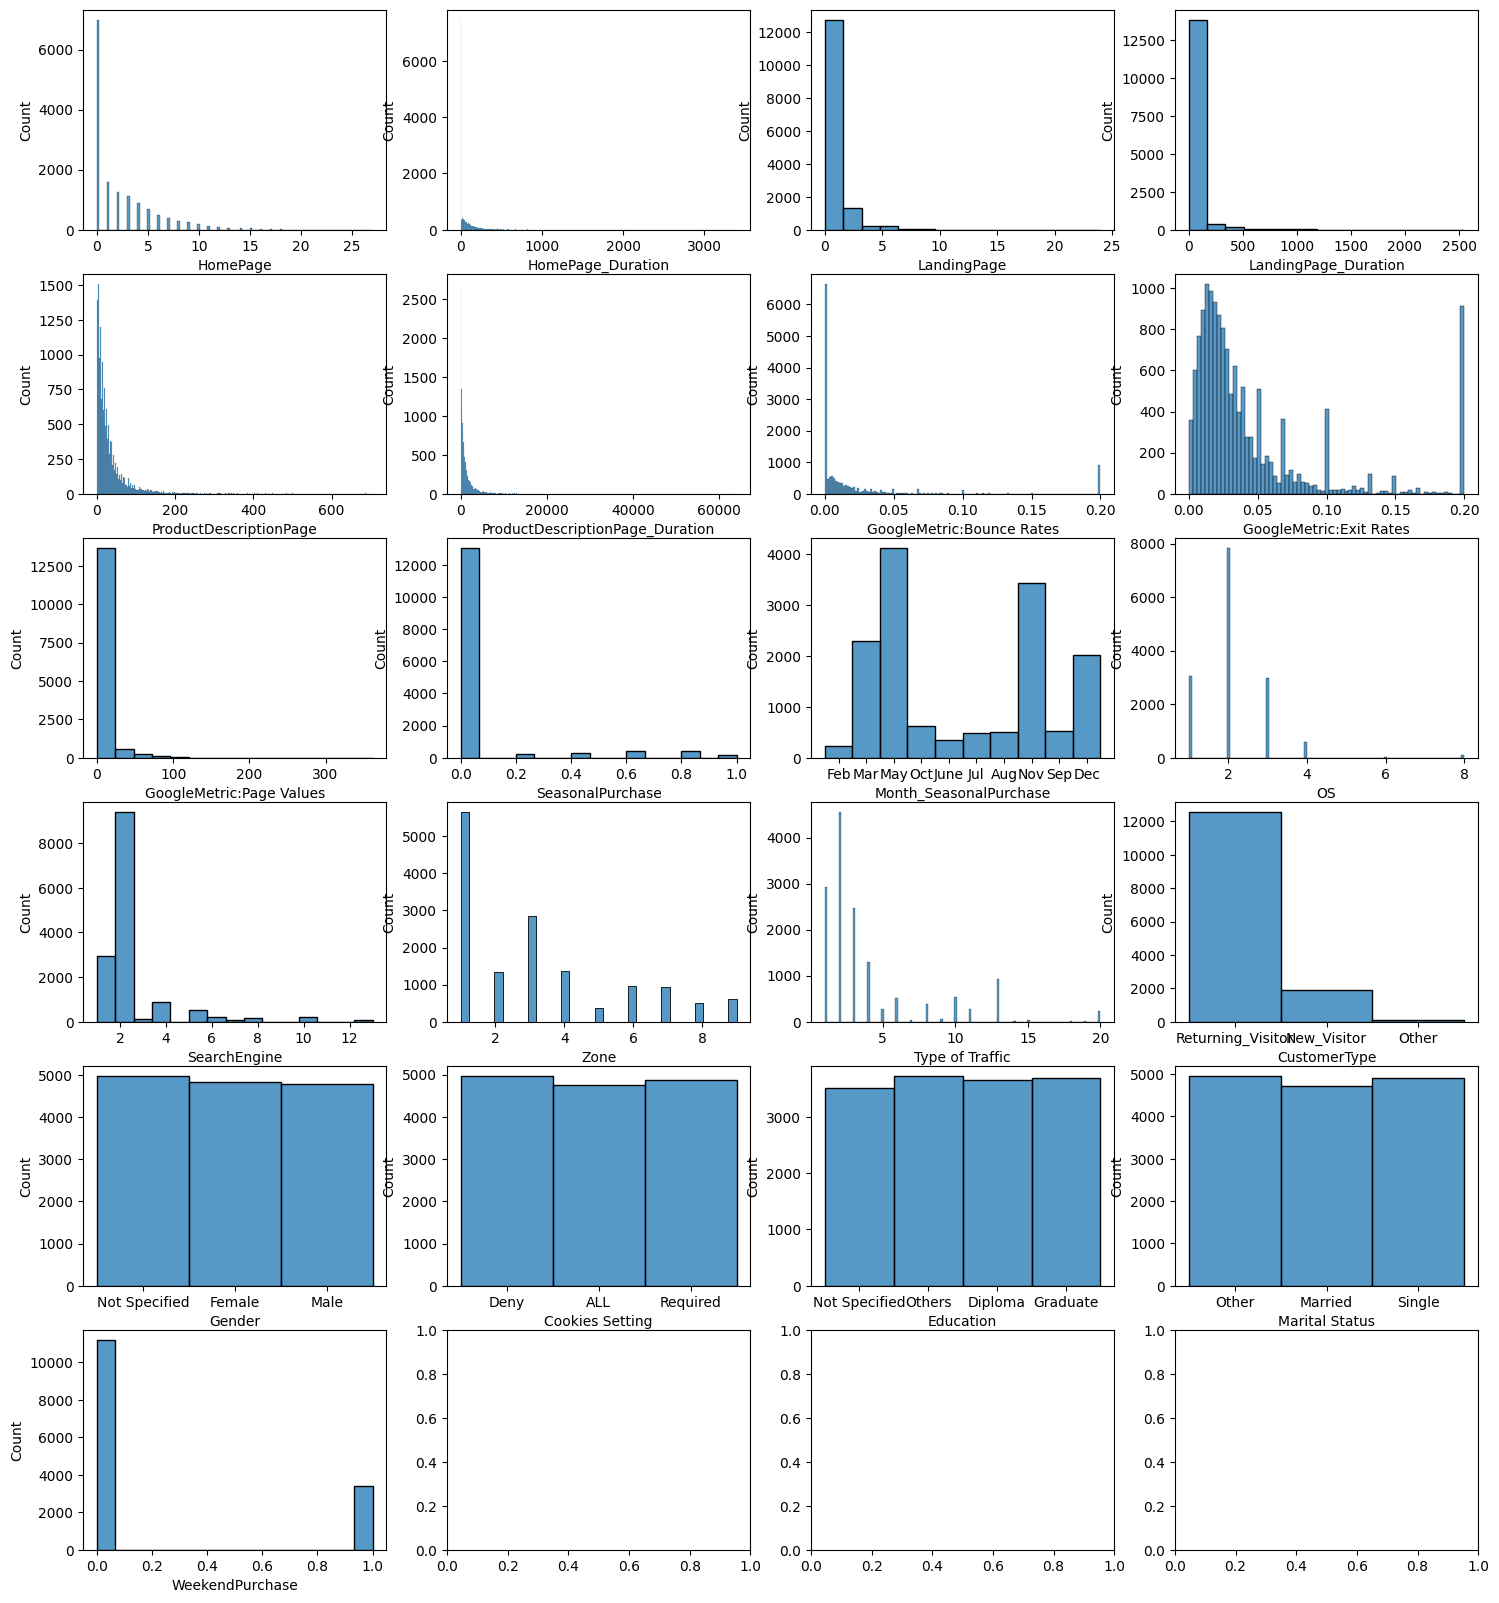

In [220]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(18, 20))

axs = axs.flatten()

for i, col in enumerate(X.columns):
  sns.histplot(X[col], ax=axs[i])

plt.show()



#### In most of the columns, the distribution appears to be right skewed.

### Rectifying datatypes of some columns

In [221]:
# OS, SearchEngine, Zone, Type of traffic should be categorical not float, weekend purchase should be boolean not float
X['OS'] = X['OS'].astype('object')
X['SearchEngine'] = X['SearchEngine'].astype('object')
X['Zone'] = X['Zone'].astype('object')
X['Type of Traffic'] = X['Type of Traffic'].astype('object')
X['Zone'] = X['Zone'].astype('object')
X['WeekendPurchase'] = X['WeekendPurchase'].astype('bool')


df_test['OS'] = df_test['OS'].astype('object')
df_test['SearchEngine'] = df_test['SearchEngine'].astype('object')
df_test['Zone'] = df_test['Zone'].astype('object')
df_test['Type of Traffic'] = df_test['Type of Traffic'].astype('object')
df_test['Zone'] = df_test['Zone'].astype('object')
df_test['WeekendPurchase'] = df_test['WeekendPurchase'].astype('bool')

### Outlier detection using boxplots

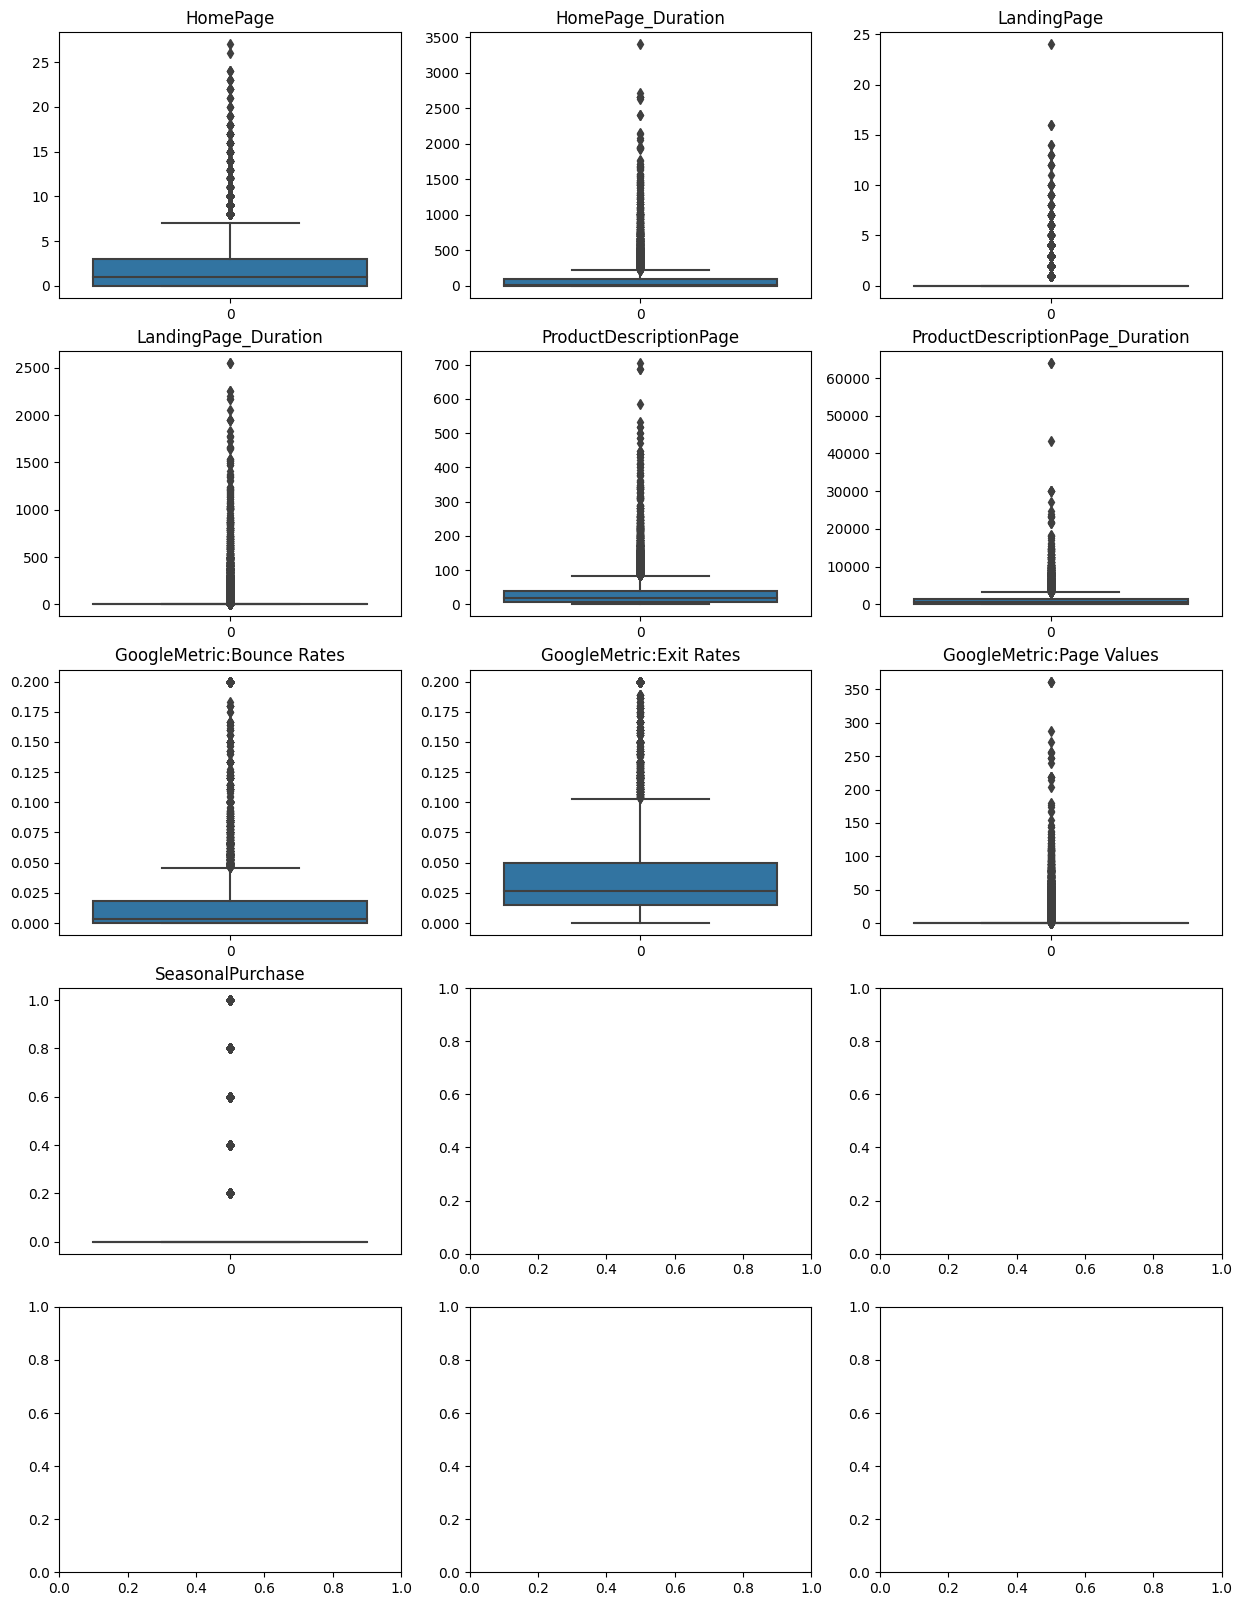

In [222]:
num_cols = [col for col in X.columns if X[col].dtype == 'float64']

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

axs = axs.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(X[col], ax=axs[i])
  axs[i].set_title(col)

plt.show()

In [223]:
#check outliers for homepage column
for col in num_cols:
  q1 = np.nanpercentile(X[col], 25, axis=0)
  q3 = np.nanpercentile(X[col], 75, axis=0)
  iqr = q3 - q1
  lb = q1 - 1.5 * iqr
  ub = q3 + 1.5 * iqr
  print(col, len(X[(X[col] > ub) | (X[col] < lb)]))

HomePage 1191
HomePage_Duration 1386
LandingPage 3053
LandingPage_Duration 2792
ProductDescriptionPage 1171
ProductDescriptionPage_Duration 1155
GoogleMetric:Bounce Rates 1827
GoogleMetric:Exit Rates 1415
GoogleMetric:Page Values 2812
SeasonalPurchase 1547


#### Finding: A lot of data points lie in the outlier range, we cannot remove all of them, as there will be a loss of data. We can assume this is some characteristic of the data.
#### We remove only the most extreme values.

In [224]:
index_list = []

index_list.extend(list(X[X['HomePage_Duration'] > 3000].index))
index_list.extend(list(X[X['LandingPage'] > 20].index))
index_list.extend(list(X[X['GoogleMetric:Page Values'] > 350].index))
index_list.extend(list(X[X['ProductDescriptionPage'] > 600].index))
X.drop(index_list, inplace=True)
y.drop(index_list, inplace=True)
print(X.shape, y.shape)

(14724, 21) (14724,)


In [225]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [226]:
y[y == True] = 1
y[y == False] = 0
y = y.astype('int')

In [227]:
y

0        0
1        0
2        0
3        0
4        0
        ..
14719    1
14720    1
14721    1
14722    1
14723    1
Name: Made_Purchase, Length: 14724, dtype: int64

In [281]:
#Distribution of labels
y.value_counts()

0    9064
1    5660
Name: Made_Purchase, dtype: int64

## Correlation analysis

<ipython-input-229-cdbfbdef3689>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_comb.corr()


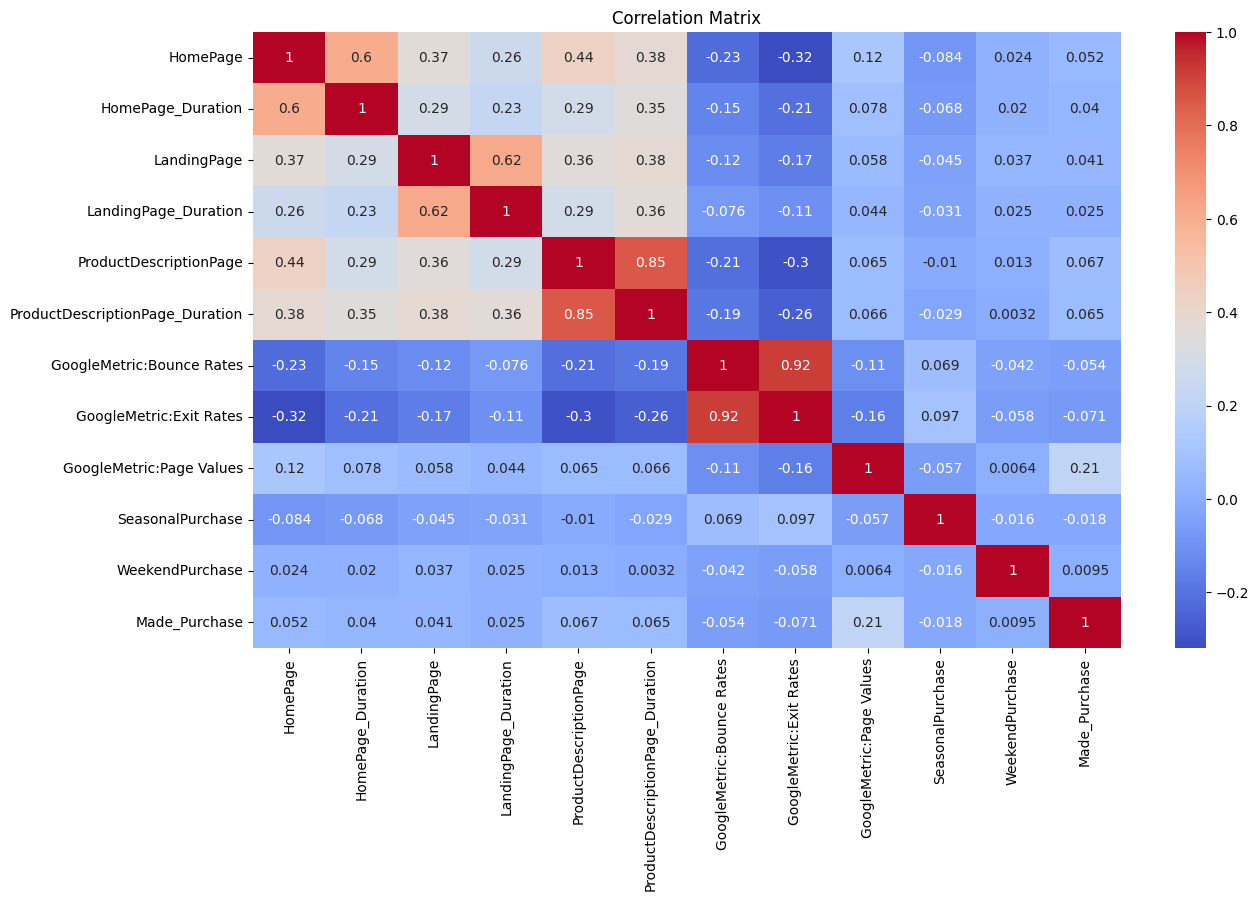

In [229]:
df_comb = X.copy()
df_comb['Made_Purchase'] = y.copy()
corr_matrix = df_comb.corr()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

### Combined highly correlated columns pairs into a single column to avoid multi-colinearity.

In [231]:
X['HomePage_comb'] = X['HomePage'] * X['HomePage_Duration']
X['LandingPage_comb'] = X['LandingPage'] * X['LandingPage_Duration']
X['ProductPage_comb'] = X['ProductDescriptionPage'] * X['ProductDescriptionPage_Duration']
X['Bounce_exit'] = X['GoogleMetric:Bounce Rates'] * X['GoogleMetric:Exit Rates']

In [232]:
X.drop(['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration', 'ProductDescriptionPage', 'ProductDescriptionPage_Duration', 'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates'], inplace=True, axis=1)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14724 entries, 0 to 14723
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GoogleMetric:Page Values  14592 non-null  float64
 1   SeasonalPurchase          14574 non-null  float64
 2   Month_SeasonalPurchase    14580 non-null  object 
 3   OS                        14590 non-null  object 
 4   SearchEngine              14602 non-null  object 
 5   Zone                      14607 non-null  object 
 6   Type of Traffic           14581 non-null  object 
 7   CustomerType              14580 non-null  object 
 8   Gender                    14579 non-null  object 
 9   Cookies Setting           14581 non-null  object 
 10  Education                 14589 non-null  object 
 11  Marital Status            14594 non-null  object 
 12  WeekendPurchase           14724 non-null  bool   
 13  HomePage_comb             14421 non-null  float64
 14  Landin

In [233]:
df_test['HomePage_comb'] = df_test['HomePage'] * df_test['HomePage_Duration']
df_test['LandingPage_comb'] = df_test['LandingPage'] * df_test['LandingPage_Duration']
df_test['ProductPage_comb'] = df_test['ProductDescriptionPage'] * df_test['ProductDescriptionPage_Duration']
df_test['Bounce_exit'] = df_test['GoogleMetric:Bounce Rates'] * df_test['GoogleMetric:Exit Rates']
df_test.drop(['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration', 'ProductDescriptionPage', 'ProductDescriptionPage_Duration', 'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates'], inplace=True, axis=1)
# df_test.drop('OS', axis=1, inplace=True)

### Correlation analysis after feature engineering

<ipython-input-234-cdbfbdef3689>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_comb.corr()


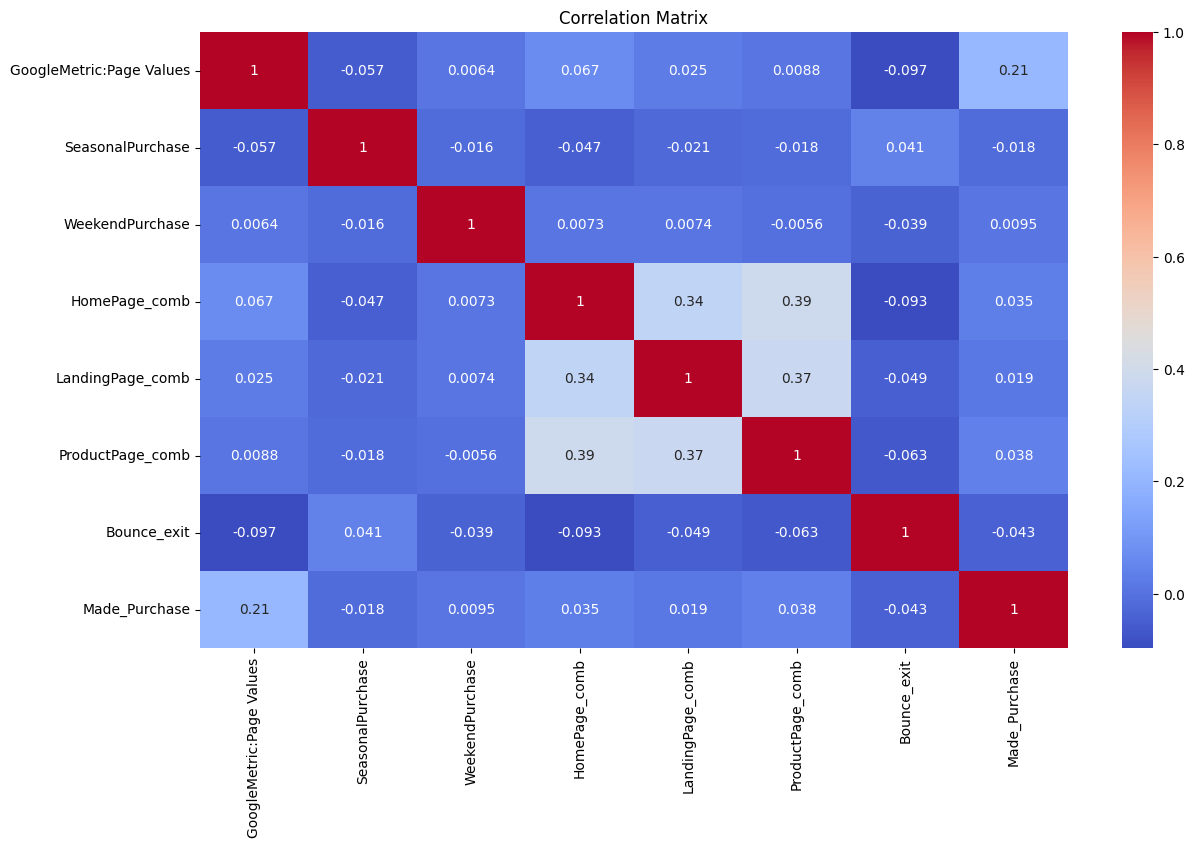

In [234]:
df_comb = X.copy()
df_comb['Made_Purchase'] = y.copy()
corr_matrix = df_comb.corr()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

In [235]:
float_cols = [col for col in X.columns if X[col].dtype == 'float64']
cat_cols = [col for col in X.columns if col not in float_cols]

## Pre-processing

In [236]:
from sklearn.model_selection import train_test_split

def split_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True)
  return X_train, X_test, y_train, y_test


In [237]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [239]:
def preprocessing(X_train, X_test, df_test):
  num_pipeline = Pipeline([
      ('knn', KNNImputer()),
      ('std_scaler', StandardScaler())
  ])

  cat_pipeline = Pipeline([
      ('sm', SimpleImputer(strategy='most_frequent')),
      ('encode', OneHotEncoder(handle_unknown='ignore'))
  ])

  pipe = ColumnTransformer([
      ('np', num_pipeline, float_cols),
      ('cp', cat_pipeline, cat_cols)
  ])

  X_train = pipe.fit_transform(X_train)
  X_test = pipe.transform(X_test)
  df_test = pipe.transform(df_test)
  return X_train, X_test, df_test


In [240]:
X_train, X_test, df_test_p = preprocessing(X_train, X_test, df_test)

### Oversampling using SMOTE to handle class imbalance

In [253]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
X_res.shape

(13596, 84)

In [55]:
#after oversampling
y_res.value_counts()

0    6798
1    6798
Name: Made_Purchase, dtype: int64

### Some common functions to train and evaluate models

In [245]:
def train_classifier(X_train, y_train, estimator):
  scores = cross_val_score(estimator=estimator, X=X_train, y=y_train, cv=5, scoring='f1')
  print(f"Training score without hyperparameter tuning based on f1 score is {scores.mean()}")

def RandomizedSearch(X_train, y_train, param_grid, estimator):
  rs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, cv=3, scoring='f1', random_state=42)
  scores = rs.fit(X_train, y_train)
  print(f"Best params are {scores.best_params_}. Best score is {scores.best_score_}")

def GridSearch(X_train, y_train, param_grid, estimator):
  gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1', cv=3)
  scores = gs.fit(X_train, y_train)
  print(f"Best params are {scores.best_params_}. Best score is {scores.best_score_}")

def evaluation(est, X_train, y_train, X_test, y_test):
  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  plt.show()

In [251]:
X_train.shape

(11043, 84)

In [153]:
#all models
models = [
    ('SGD_SVM', SGDClassifier(random_state=42, class_weight='balanced')),
    ('SGD_perceptron', SGDClassifier(random_state=42, loss='perceptron', class_weight='balanced')),
    ('Logistic', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('rfc', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('adb', AdaBoostClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
    ]


### Training models with feature selection

NUMBER OF FEATURES SELECTED:  20
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.40034441298004075
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      2266
           1       0.49      0.34      0.40      1415

    accuracy                           0.61      3681
   macro avg       0.57      0.56      0.56      3681
weighted avg       0.59      0.61      0.59      3681



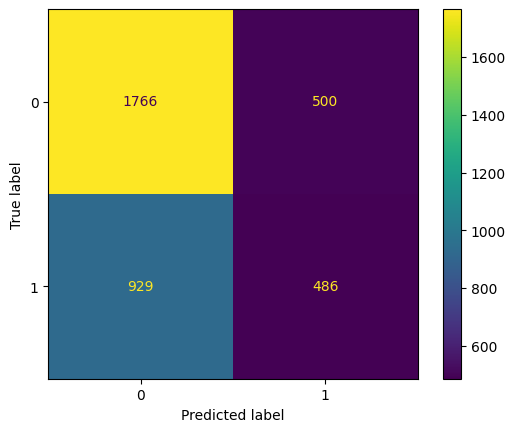

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.44133446682223576
              precision    recall  f1-score   support

           0       0.64      0.88      0.74      2266
           1       0.53      0.22      0.31      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.55      0.53      3681
weighted avg       0.60      0.63      0.58      3681



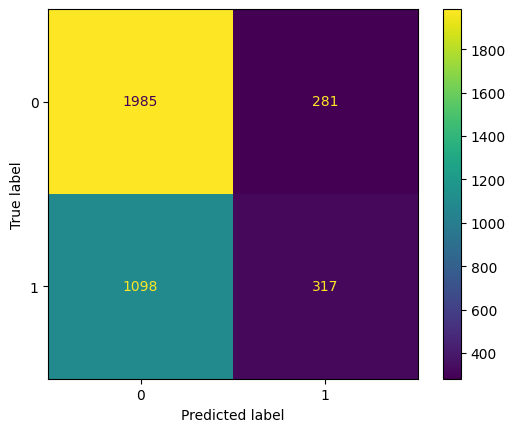

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.44239403311664505
              precision    recall  f1-score   support

           0       0.66      0.83      0.74      2266
           1       0.55      0.33      0.41      1415

    accuracy                           0.64      3681
   macro avg       0.61      0.58      0.57      3681
weighted avg       0.62      0.64      0.61      3681



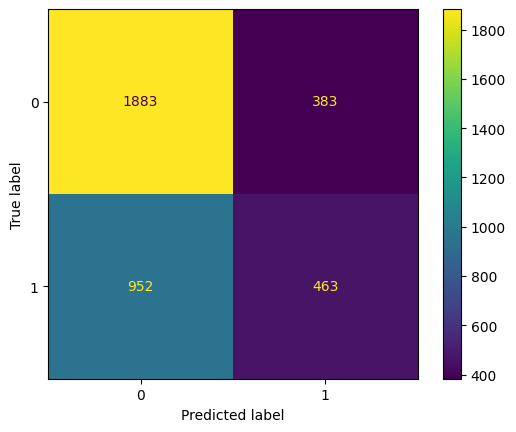

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.3449314793425845
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      2266
           1       0.31      0.37      0.34      1415

    accuracy                           0.44      3681
   macro avg       0.43      0.42      0.42      3681
weighted avg       0.46      0.44      0.44      3681



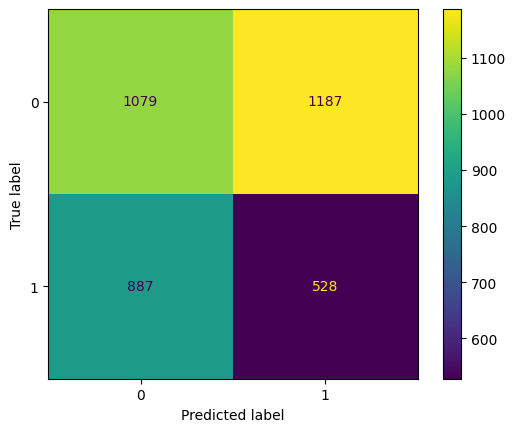

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.34037021327851397
              precision    recall  f1-score   support

           0       0.59      0.62      0.61      2266
           1       0.34      0.31      0.32      1415

    accuracy                           0.50      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.49      0.50      0.50      3681



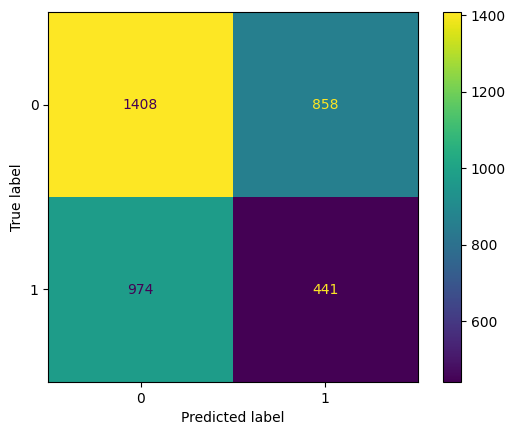

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.38390037957784157
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.63      0.26      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



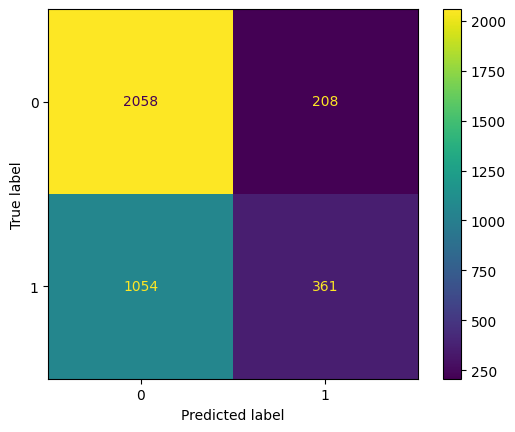

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.40562209354549894
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2266
           1       0.61      0.27      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.57      3681
weighted avg       0.64      0.65      0.61      3681



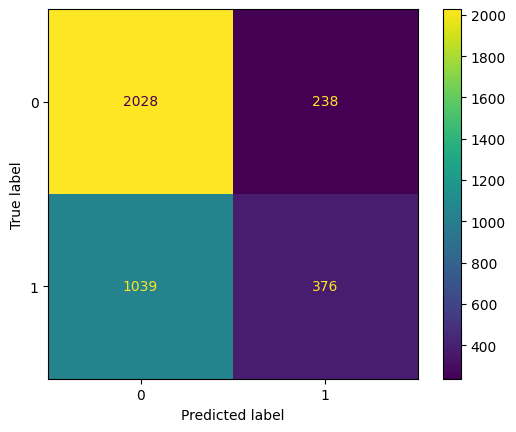

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.3589162591647447
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      2266
           1       0.50      0.24      0.32      1415

    accuracy                           0.61      3681
   macro avg       0.57      0.54      0.53      3681
weighted avg       0.59      0.61      0.57      3681



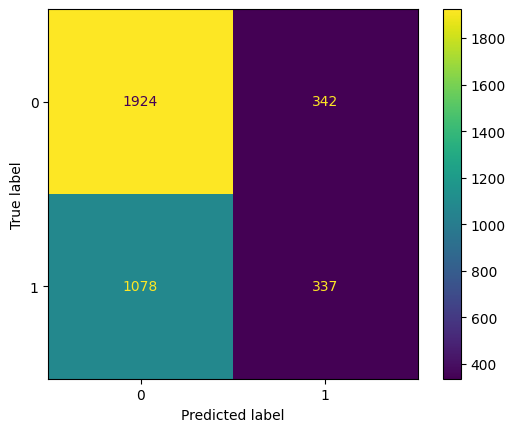

NUMBER OF FEATURES SELECTED:  30
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.40720129093082846
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      2266
           1       0.46      0.45      0.46      1415

    accuracy                           0.59      3681
   macro avg       0.56      0.56      0.56      3681
weighted avg       0.59      0.59      0.59      3681



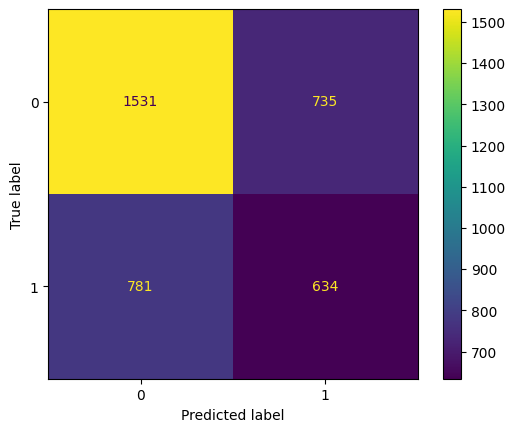

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5087495264494559
              precision    recall  f1-score   support

           0       0.62      0.41      0.50      2266
           1       0.39      0.59      0.47      1415

    accuracy                           0.48      3681
   macro avg       0.50      0.50      0.48      3681
weighted avg       0.53      0.48      0.49      3681



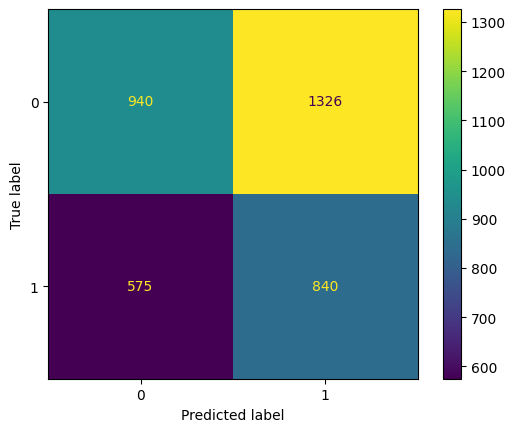

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.43917380815892687
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      2266
           1       0.53      0.35      0.42      1415

    accuracy                           0.63      3681
   macro avg       0.60      0.58      0.57      3681
weighted avg       0.61      0.63      0.61      3681



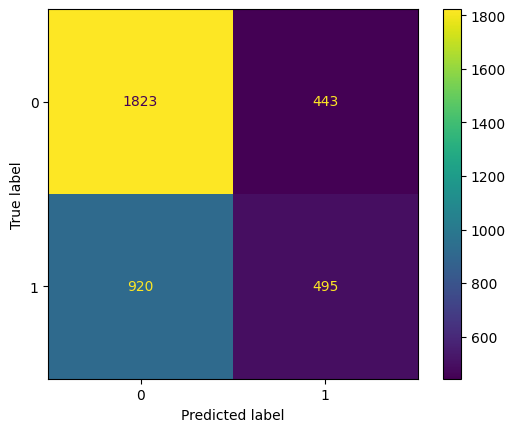

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.348797910247831
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      2266
           1       0.29      0.36      0.32      1415

    accuracy                           0.42      3681
   macro avg       0.41      0.41      0.41      3681
weighted avg       0.44      0.42      0.42      3681



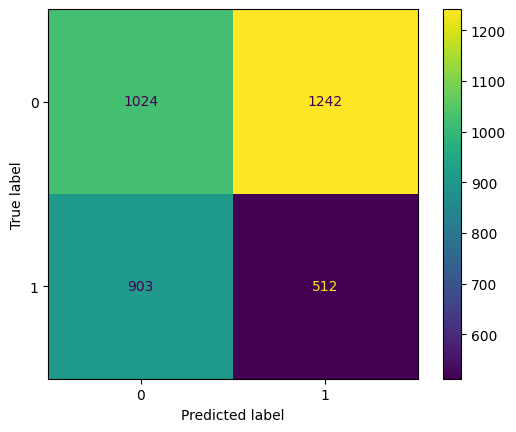

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.337421460417874
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      2266
           1       0.32      0.28      0.30      1415

    accuracy                           0.49      3681
   macro avg       0.45      0.45      0.45      3681
weighted avg       0.48      0.49      0.49      3681



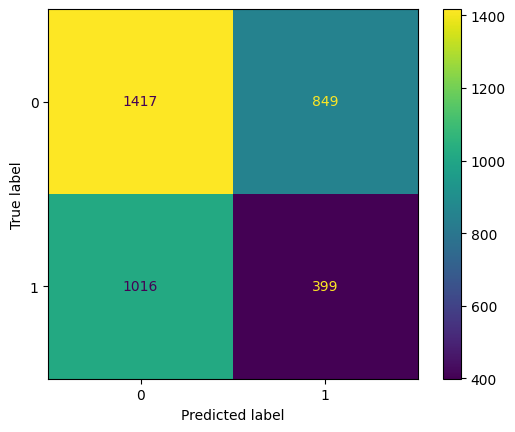

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3846725574156336
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.64      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



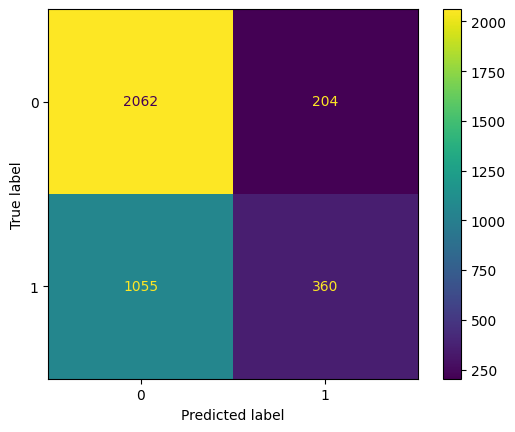

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.40438347875005
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.36      1415

    accuracy                           0.65      3681
   macro avg       0.63      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



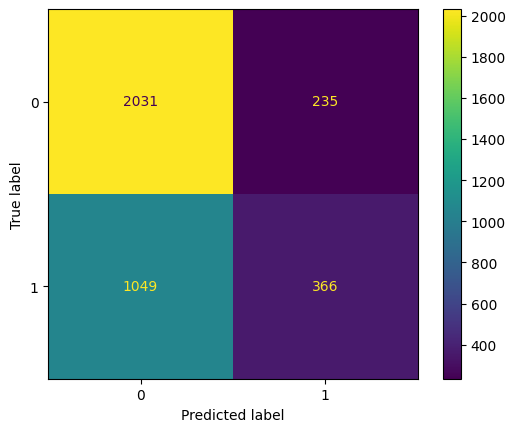

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.35303586956169103
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      2266
           1       0.50      0.24      0.32      1415

    accuracy                           0.62      3681
   macro avg       0.57      0.54      0.53      3681
weighted avg       0.59      0.62      0.57      3681



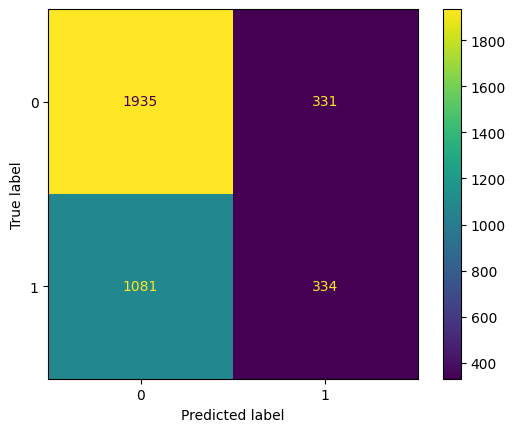

NUMBER OF FEATURES SELECTED:  40
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.4559847118747662
              precision    recall  f1-score   support

           0       0.65      0.91      0.76      2266
           1       0.60      0.22      0.32      1415

    accuracy                           0.64      3681
   macro avg       0.63      0.56      0.54      3681
weighted avg       0.63      0.64      0.59      3681



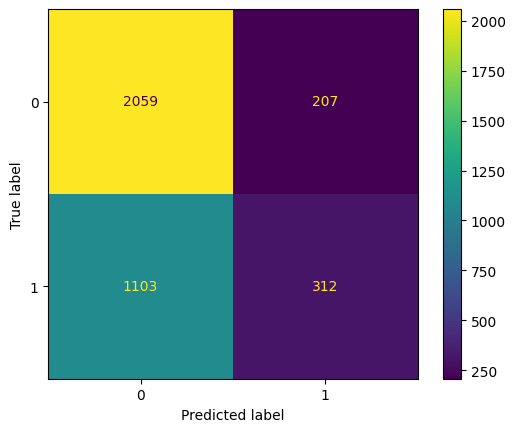

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5284944450112036
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      2266
           1       0.48      0.35      0.41      1415

    accuracy                           0.61      3681
   macro avg       0.57      0.56      0.56      3681
weighted avg       0.59      0.61      0.59      3681



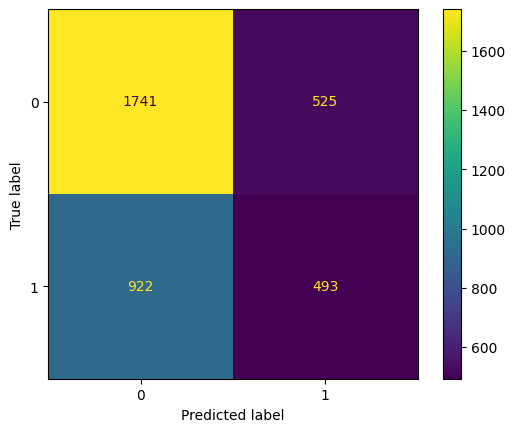

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.4384442803452885
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      2266
           1       0.52      0.35      0.42      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.61      0.63      0.61      3681



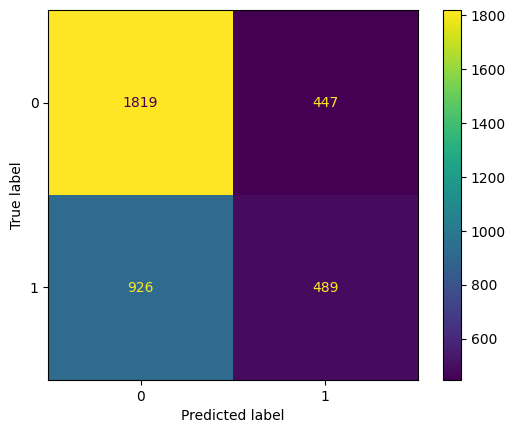

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.345030831714185
              precision    recall  f1-score   support

           0       0.53      0.46      0.49      2266
           1       0.29      0.35      0.31      1415

    accuracy                           0.42      3681
   macro avg       0.41      0.40      0.40      3681
weighted avg       0.44      0.42      0.42      3681



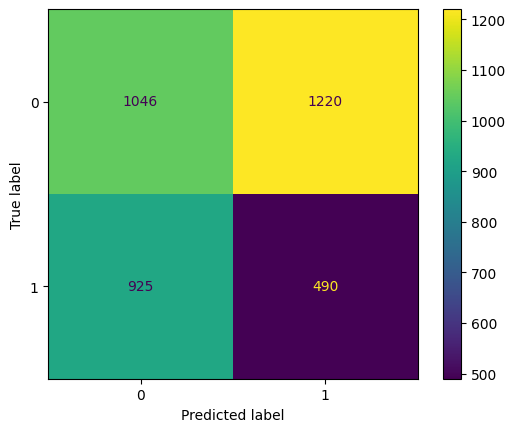

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.32738221027370307
              precision    recall  f1-score   support

           0       0.59      0.66      0.63      2266
           1       0.33      0.27      0.30      1415

    accuracy                           0.51      3681
   macro avg       0.46      0.47      0.46      3681
weighted avg       0.49      0.51      0.50      3681



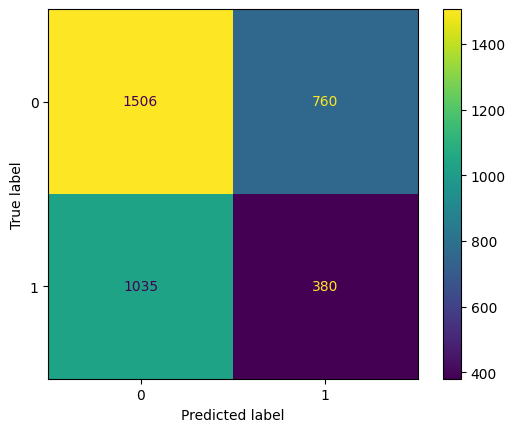

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3834225394762853
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.63      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



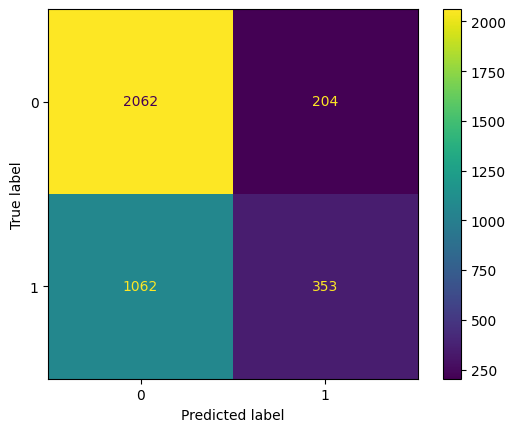

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.4043992944173162
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2266
           1       0.61      0.27      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.57      3681
weighted avg       0.64      0.65      0.61      3681



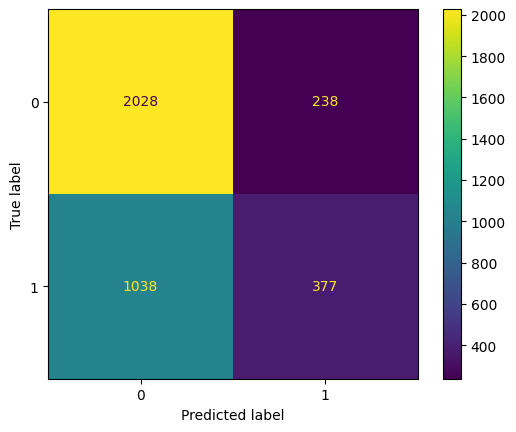

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.35112812011906047
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      2266
           1       0.48      0.24      0.32      1415

    accuracy                           0.61      3681
   macro avg       0.56      0.54      0.52      3681
weighted avg       0.58      0.61      0.57      3681



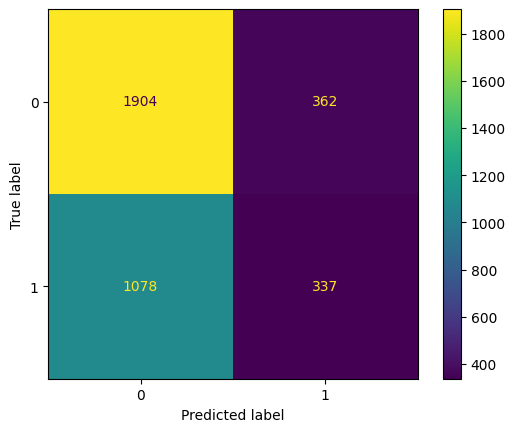

NUMBER OF FEATURES SELECTED:  50
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.4240667232321399
              precision    recall  f1-score   support

           0       0.66      0.86      0.74      2266
           1       0.56      0.29      0.38      1415

    accuracy                           0.64      3681
   macro avg       0.61      0.57      0.56      3681
weighted avg       0.62      0.64      0.60      3681



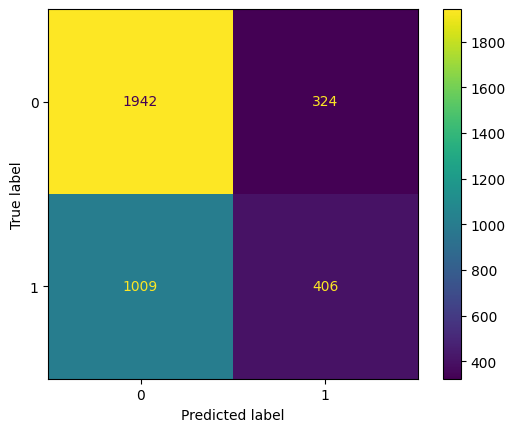

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5114300863943559
              precision    recall  f1-score   support

           0       0.64      0.49      0.56      2266
           1       0.41      0.55      0.47      1415

    accuracy                           0.52      3681
   macro avg       0.52      0.52      0.51      3681
weighted avg       0.55      0.52      0.52      3681



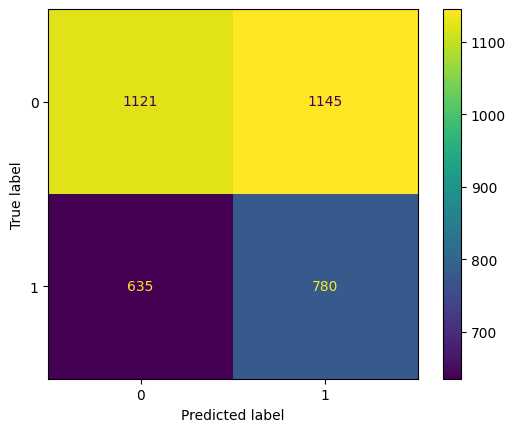

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.4389016396016278
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2266
           1       0.53      0.35      0.42      1415

    accuracy                           0.63      3681
   macro avg       0.60      0.58      0.57      3681
weighted avg       0.61      0.63      0.61      3681



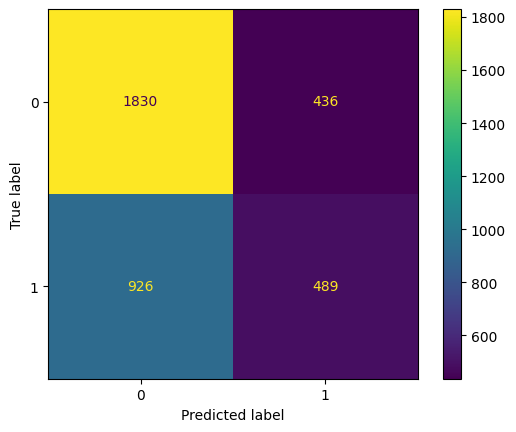

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.3440193735245123
              precision    recall  f1-score   support

           0       0.54      0.46      0.50      2266
           1       0.30      0.37      0.33      1415

    accuracy                           0.43      3681
   macro avg       0.42      0.42      0.41      3681
weighted avg       0.45      0.43      0.43      3681



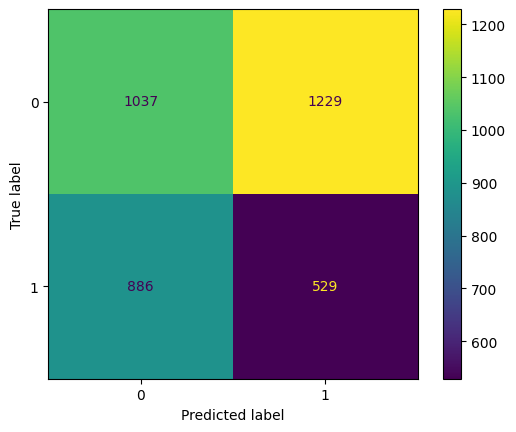

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.32328805237525493
              precision    recall  f1-score   support

           0       0.59      0.67      0.63      2266
           1       0.33      0.26      0.29      1415

    accuracy                           0.52      3681
   macro avg       0.46      0.47      0.46      3681
weighted avg       0.49      0.52      0.50      3681



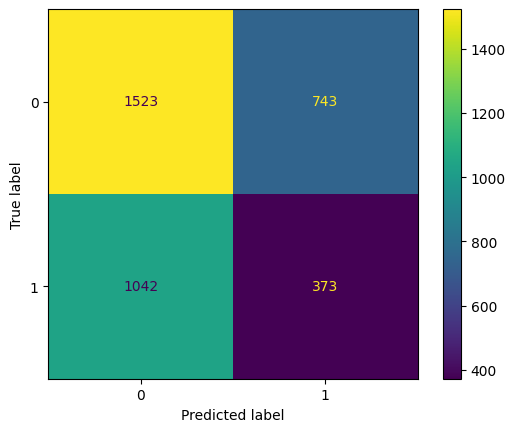

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3841193249065482
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.63      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



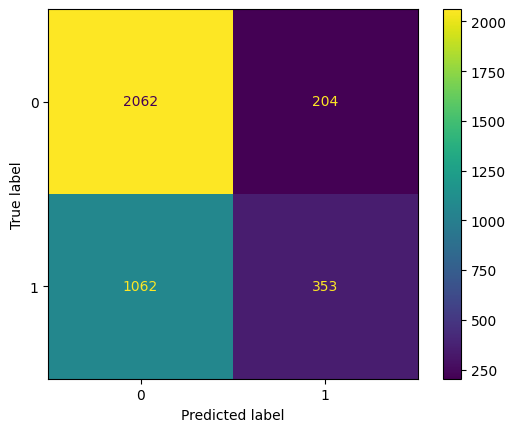

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.40635295212182265
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



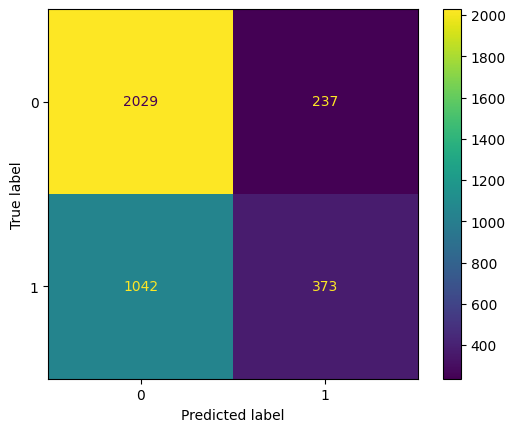

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.3454464741996142
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      2266
           1       0.47      0.24      0.32      1415

    accuracy                           0.61      3681
   macro avg       0.56      0.54      0.52      3681
weighted avg       0.57      0.61      0.57      3681



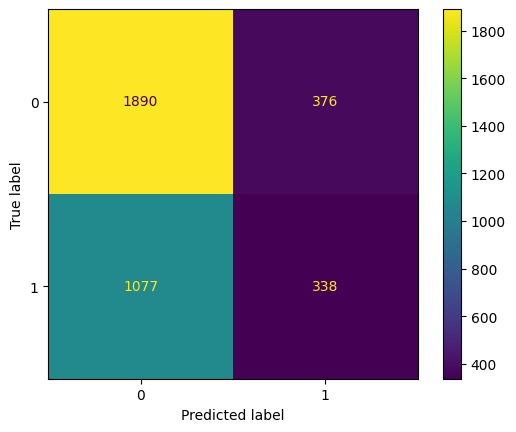

NUMBER OF FEATURES SELECTED:  60
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.4319085993189994
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      2266
           1       0.64      0.16      0.26      1415

    accuracy                           0.64      3681
   macro avg       0.64      0.55      0.51      3681
weighted avg       0.64      0.64      0.57      3681



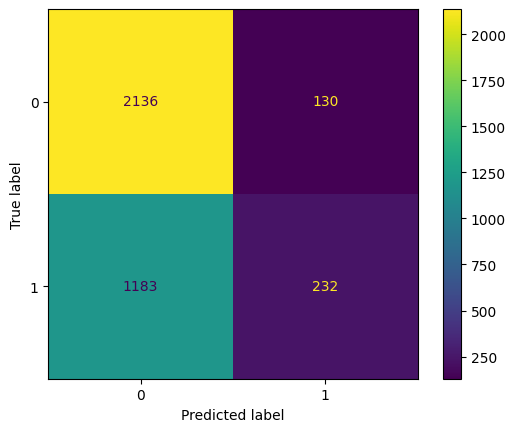

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5004052861505172
              precision    recall  f1-score   support

           0       0.65      0.29      0.40      2266
           1       0.40      0.75      0.52      1415

    accuracy                           0.47      3681
   macro avg       0.53      0.52      0.46      3681
weighted avg       0.55      0.47      0.45      3681



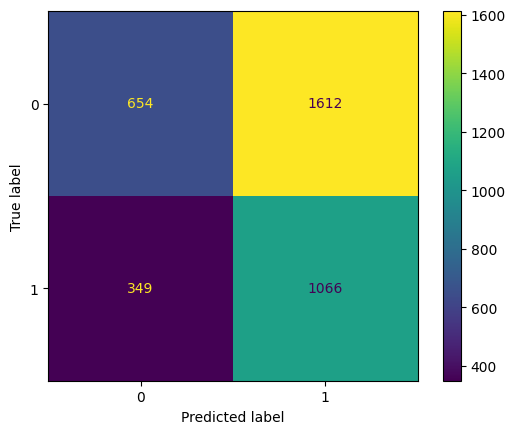

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.4414789370628792
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      2266
           1       0.53      0.35      0.42      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.58      0.57      3681
weighted avg       0.61      0.63      0.61      3681



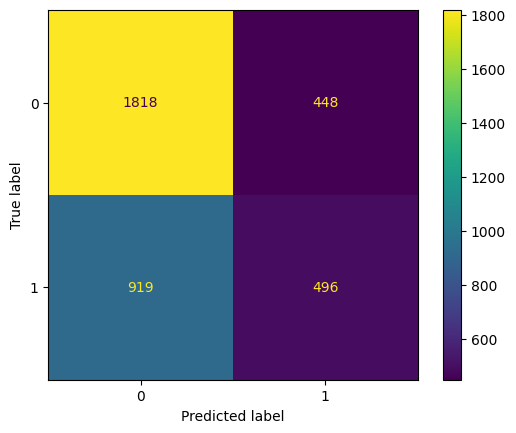

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.3480187262178294
              precision    recall  f1-score   support

           0       0.54      0.47      0.50      2266
           1       0.30      0.36      0.33      1415

    accuracy                           0.43      3681
   macro avg       0.42      0.41      0.41      3681
weighted avg       0.45      0.43      0.43      3681



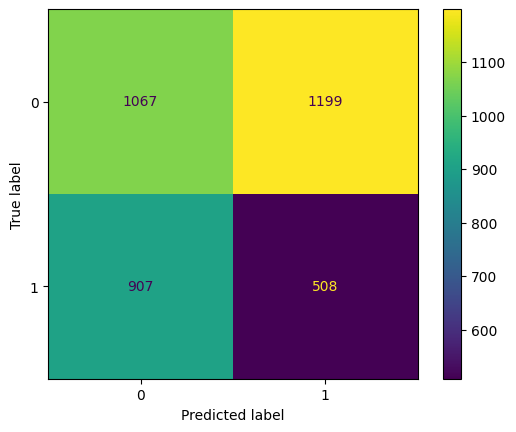

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.32256344247936597
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      2266
           1       0.34      0.27      0.30      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.52      0.50      3681



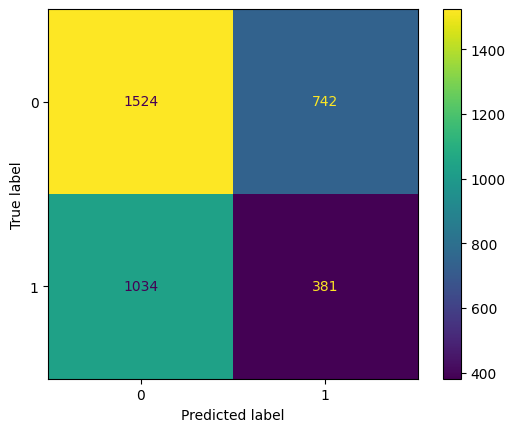

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3826487090997725
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.63      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



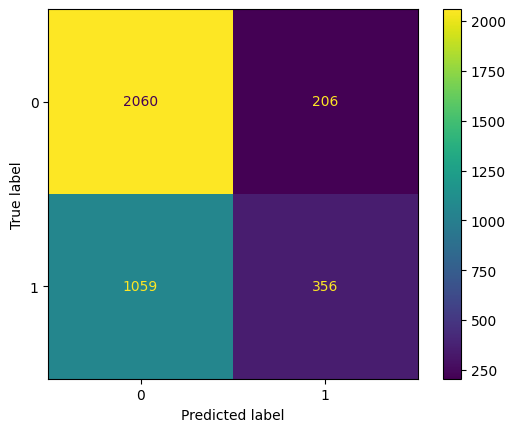

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.40634850439377146
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



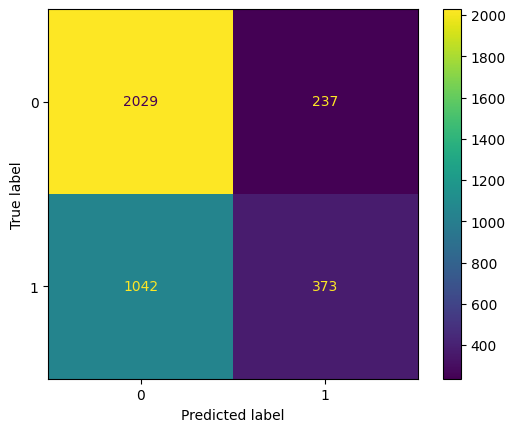

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.352471409828997
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      2266
           1       0.48      0.24      0.32      1415

    accuracy                           0.61      3681
   macro avg       0.56      0.54      0.52      3681
weighted avg       0.58      0.61      0.57      3681



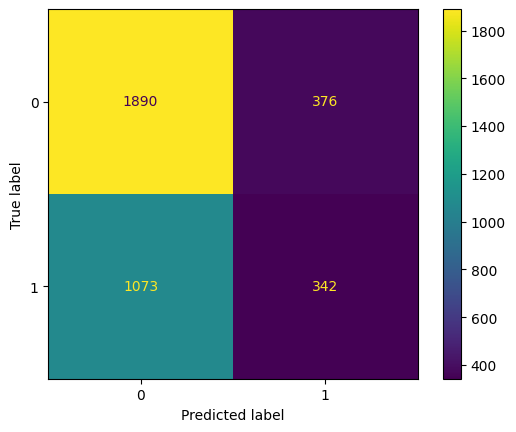

NUMBER OF FEATURES SELECTED:  70
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.457554992865871
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2266
           1       0.45      0.43      0.44      1415

    accuracy                           0.58      3681
   macro avg       0.55      0.55      0.55      3681
weighted avg       0.57      0.58      0.58      3681



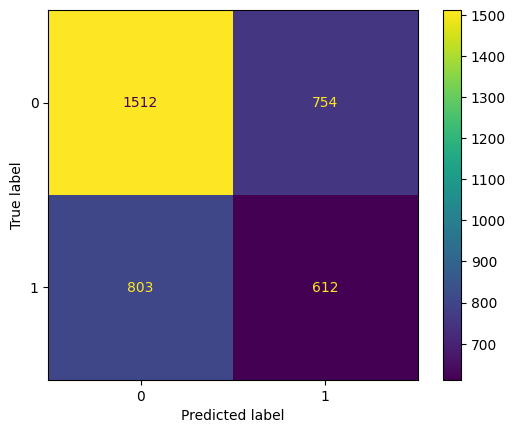

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.3984934933983132
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      2266
           1       0.45      0.51      0.48      1415

    accuracy                           0.57      3681
   macro avg       0.55      0.56      0.55      3681
weighted avg       0.58      0.57      0.57      3681



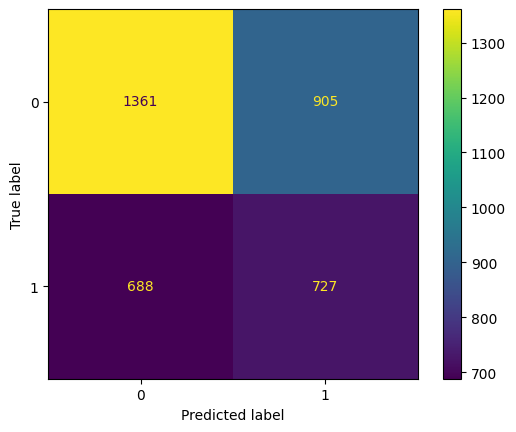

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.43889018237715777
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      2266
           1       0.52      0.35      0.42      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.61      0.62      0.61      3681



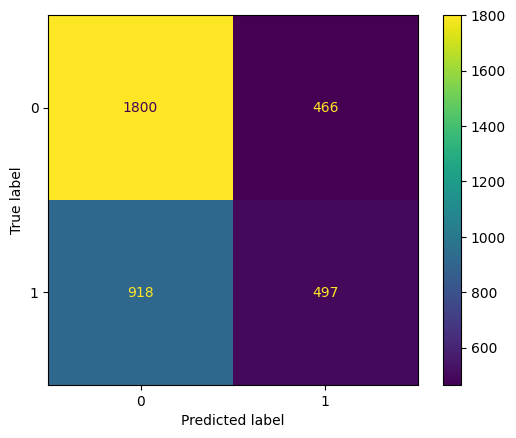

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.34400332988814253
              precision    recall  f1-score   support

           0       0.54      0.46      0.50      2266
           1       0.30      0.37      0.33      1415

    accuracy                           0.42      3681
   macro avg       0.42      0.41      0.41      3681
weighted avg       0.45      0.42      0.43      3681



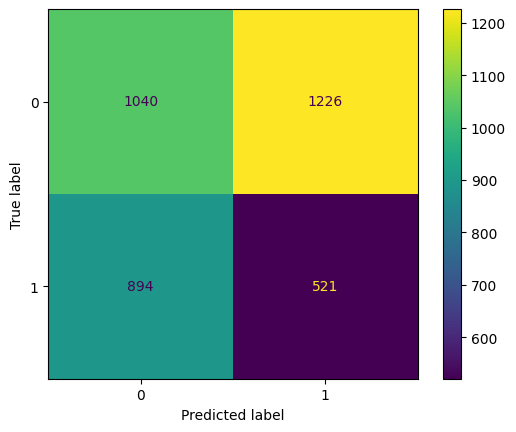

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.3208085270259548
              precision    recall  f1-score   support

           0       0.59      0.67      0.63      2266
           1       0.34      0.26      0.30      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.47      0.46      3681
weighted avg       0.50      0.52      0.50      3681



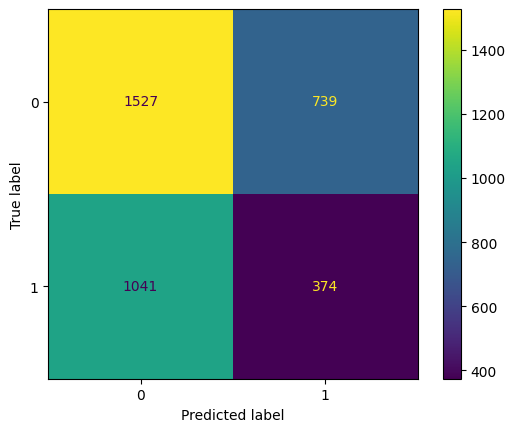

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3819877991642155
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.63      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



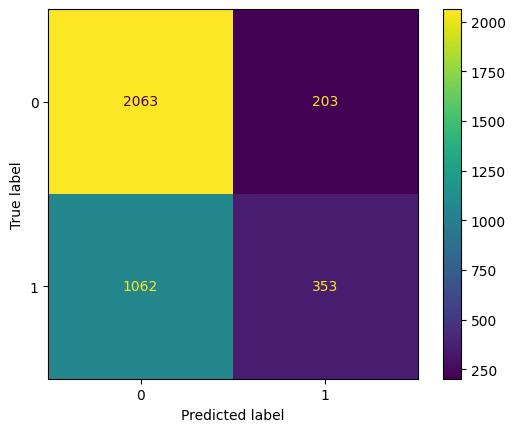

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.40629031424676515
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



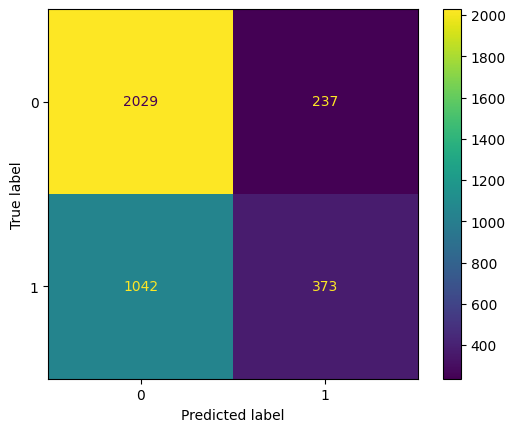

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.3437236721851224
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      2266
           1       0.46      0.24      0.31      1415

    accuracy                           0.60      3681
   macro avg       0.55      0.53      0.52      3681
weighted avg       0.57      0.60      0.56      3681



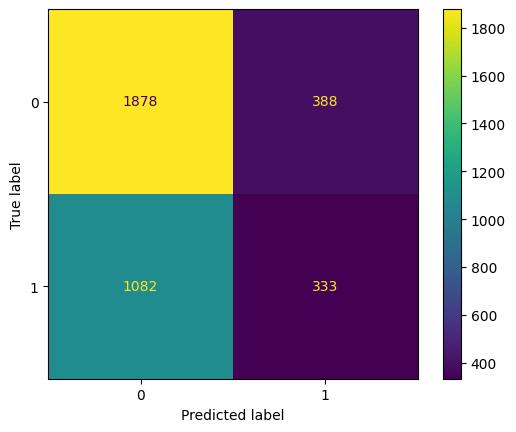

NUMBER OF FEATURES SELECTED:  80
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.4757490403386049
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      2266
           1       0.46      0.42      0.44      1415

    accuracy                           0.59      3681
   macro avg       0.56      0.56      0.56      3681
weighted avg       0.58      0.59      0.58      3681



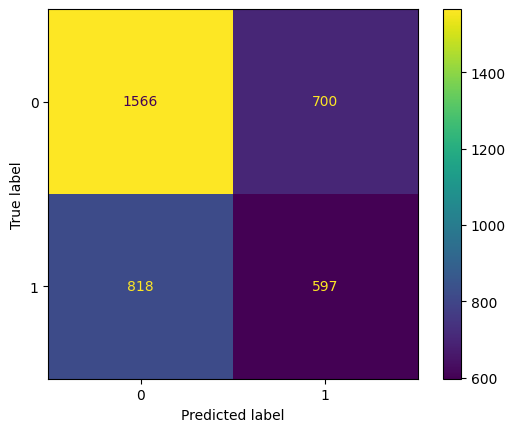

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.4090672976457233
              precision    recall  f1-score   support

           0       0.65      0.48      0.55      2266
           1       0.41      0.59      0.48      1415

    accuracy                           0.52      3681
   macro avg       0.53      0.53      0.52      3681
weighted avg       0.56      0.52      0.53      3681



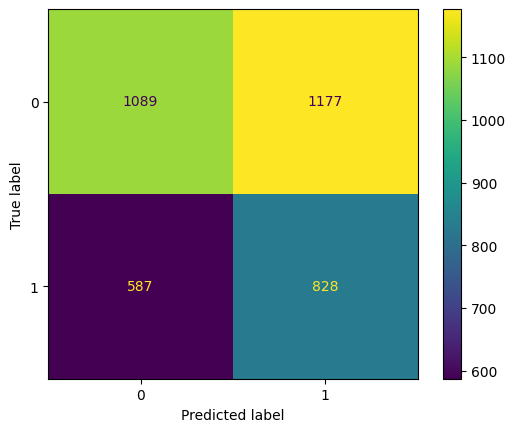

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.43722157822388974
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      2266
           1       0.52      0.35      0.42      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.61      0.62      0.61      3681



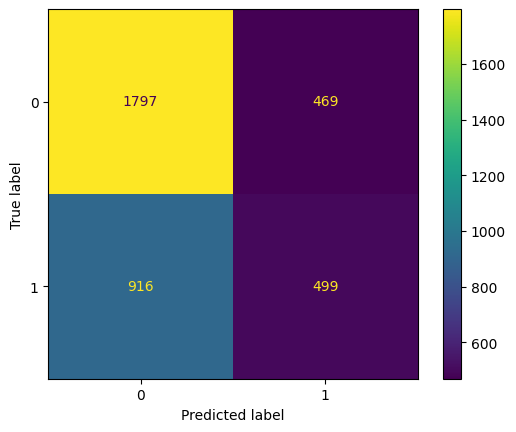

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.3444961990795682
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      2266
           1       0.29      0.36      0.32      1415

    accuracy                           0.42      3681
   macro avg       0.41      0.41      0.41      3681
weighted avg       0.44      0.42      0.42      3681



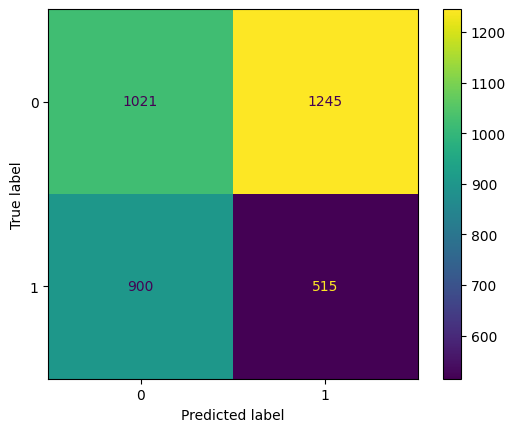

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.3148268522318042
              precision    recall  f1-score   support

           0       0.60      0.68      0.63      2266
           1       0.34      0.26      0.30      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.52      0.50      3681



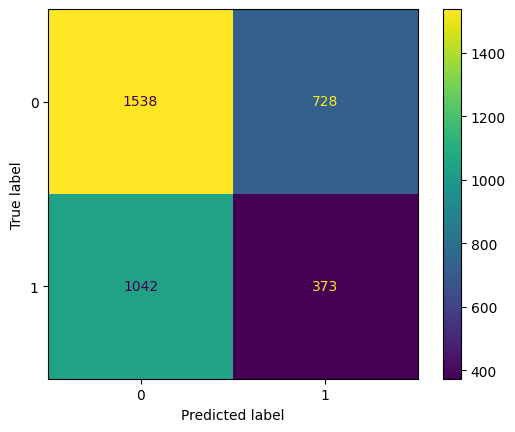

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3838474175217191
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.64      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



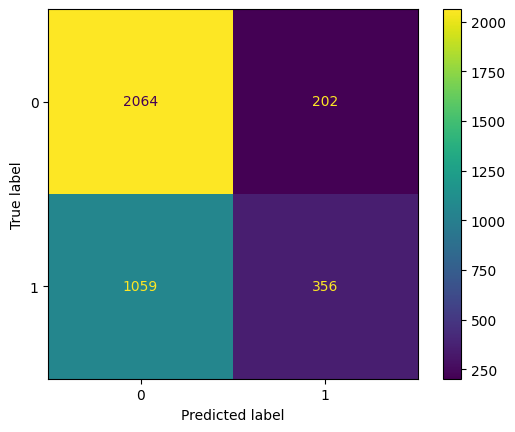

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.4060263005953275
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



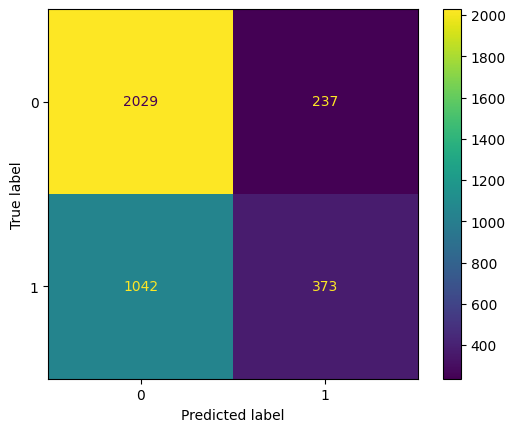

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.34893061773076994
              precision    recall  f1-score   support

           0       0.64      0.84      0.72      2266
           1       0.48      0.23      0.31      1415

    accuracy                           0.61      3681
   macro avg       0.56      0.54      0.52      3681
weighted avg       0.58      0.61      0.57      3681



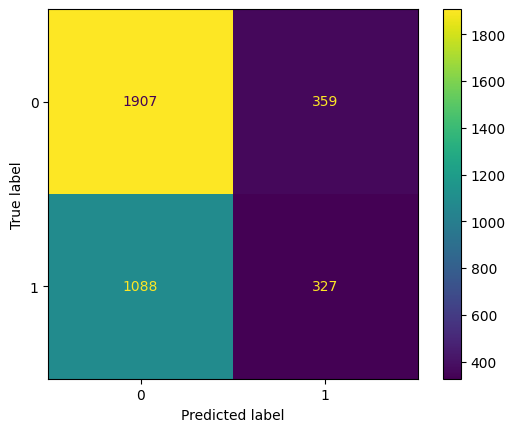

NUMBER OF FEATURES SELECTED:  84
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.44951240320798524
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2266
           1       0.56      0.25      0.34      1415

    accuracy                           0.64      3681
   macro avg       0.61      0.56      0.55      3681
weighted avg       0.62      0.64      0.59      3681



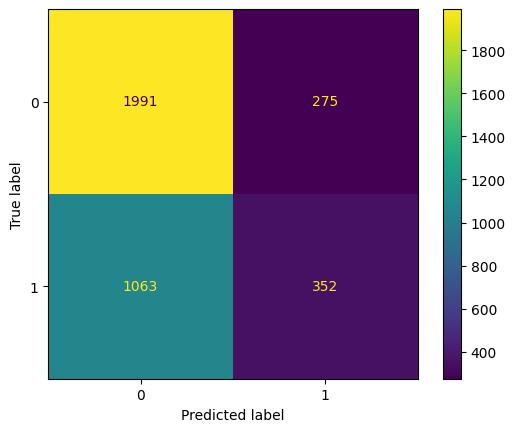

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.44317513487280846
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      2266
           1       0.40      0.44      0.42      1415

    accuracy                           0.53      3681
   macro avg       0.51      0.51      0.51      3681
weighted avg       0.54      0.53      0.53      3681



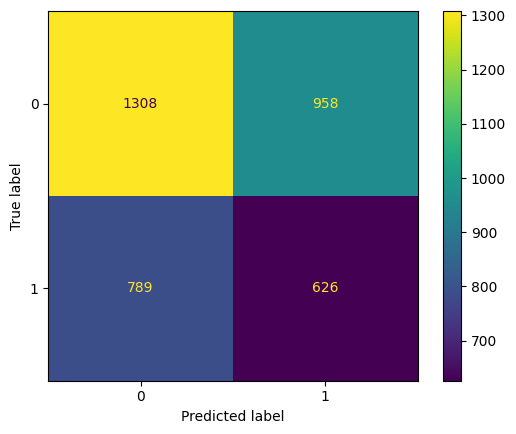

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.43783243118203474
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      2266
           1       0.52      0.35      0.42      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.61      0.62      0.61      3681



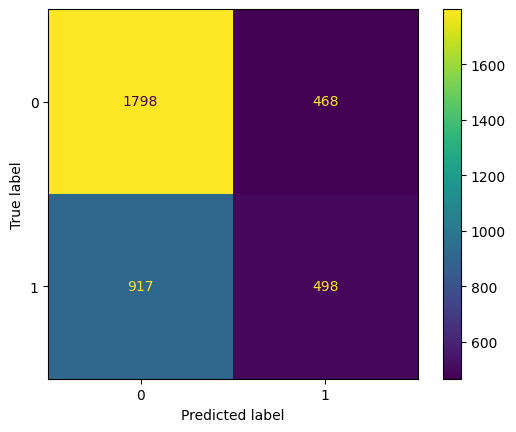

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.33917219149791844
              precision    recall  f1-score   support

           0       0.52      0.44      0.48      2266
           1       0.28      0.36      0.32      1415

    accuracy                           0.41      3681
   macro avg       0.40      0.40      0.40      3681
weighted avg       0.43      0.41      0.42      3681



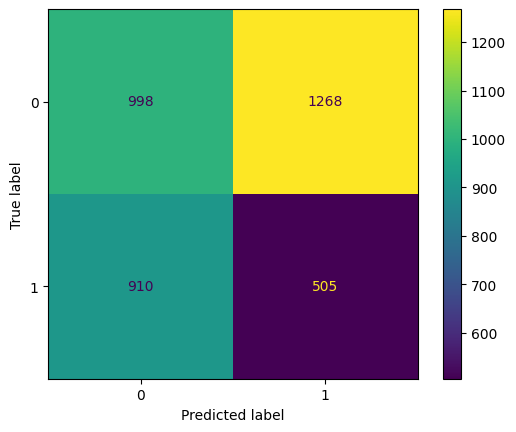

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.3211540956720381
              precision    recall  f1-score   support

           0       0.60      0.68      0.64      2266
           1       0.35      0.27      0.30      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.48      0.47      3681
weighted avg       0.50      0.52      0.51      3681



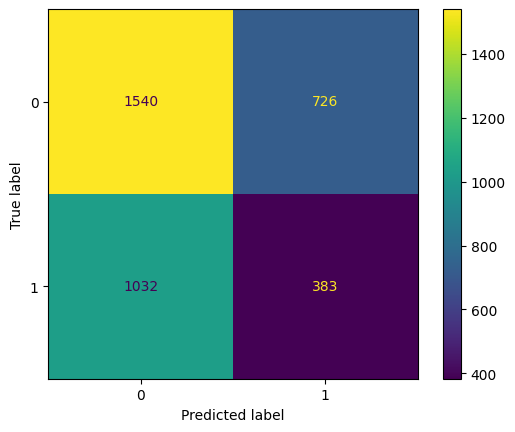

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.3840146688584192
              precision    recall  f1-score   support

           0       0.66      0.91      0.77      2266
           1       0.64      0.25      0.36      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.58      0.56      3681
weighted avg       0.65      0.66      0.61      3681



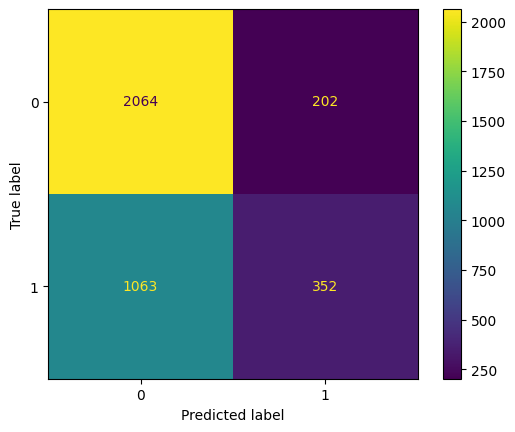

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.4067481515005974
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      2266
           1       0.61      0.26      0.37      1415

    accuracy                           0.65      3681
   macro avg       0.64      0.58      0.56      3681
weighted avg       0.64      0.65      0.61      3681



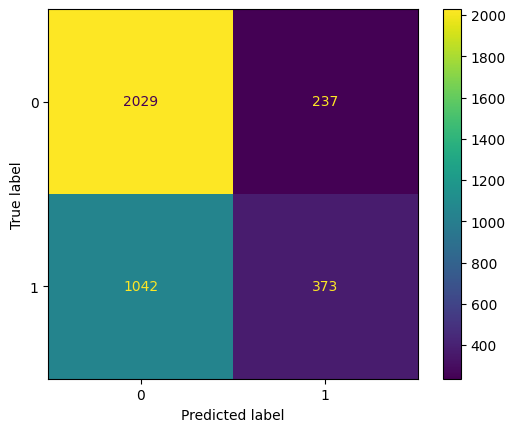

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.34645642391584486
              precision    recall  f1-score   support

           0       0.64      0.84      0.72      2266
           1       0.48      0.24      0.32      1415

    accuracy                           0.61      3681
   macro avg       0.56      0.54      0.52      3681
weighted avg       0.58      0.61      0.57      3681



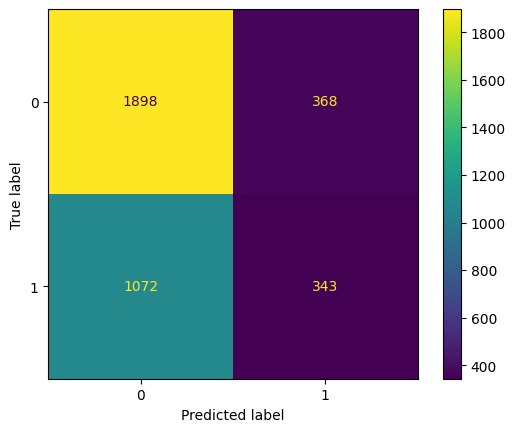

In [252]:
k_s = [20, 30, 40, 50, 60, 70, 80, 84]

for k in k_s:
  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  print("NUMBER OF FEATURES SELECTED: ", k)
  for name, model in models:
    print("MODEL: ", name)
    train_classifier(X_train_selected, y_train, model)
    evaluation(model, X_train_selected, y_train, X_test_selected, y_test)


### Oversampled data: Training models with feature selection

NUMBER OF FEATURES SELECTED:  20
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.43283860582291356
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2266
           1       0.53      0.34      0.41      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.61      0.63      0.61      3681



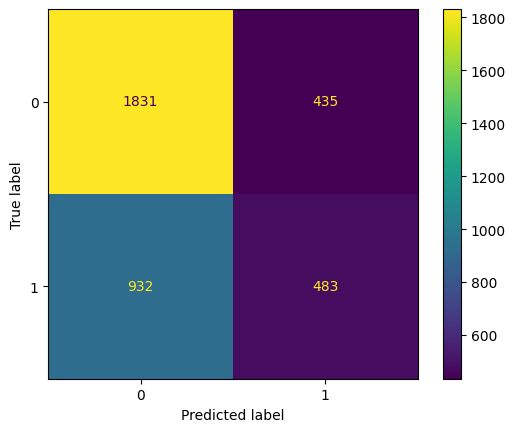

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.4488324062850797
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      2266
           1       0.41      0.48      0.44      1415

    accuracy                           0.54      3681
   macro avg       0.53      0.53      0.53      3681
weighted avg       0.55      0.54      0.54      3681



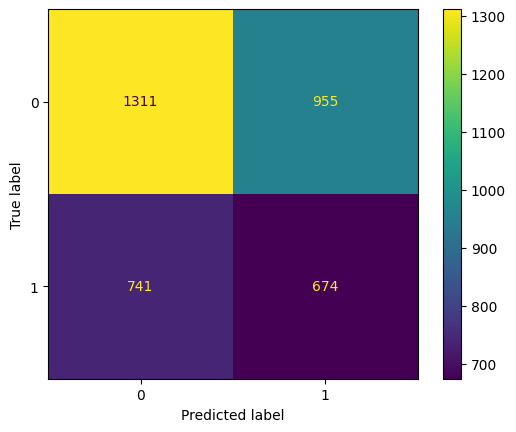

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.49564798360156787
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2266
           1       0.52      0.38      0.44      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.58      0.58      3681
weighted avg       0.61      0.63      0.61      3681



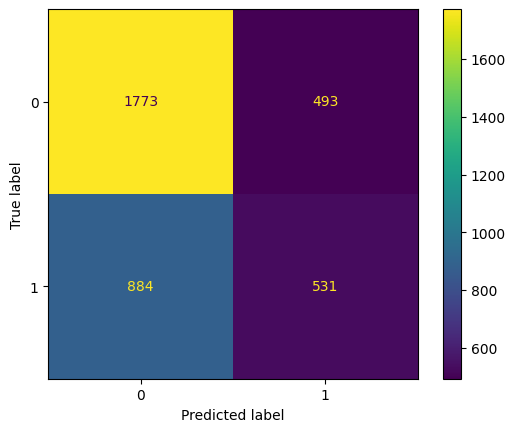

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5141791489623465
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      2266
           1       0.31      0.29      0.30      1415

    accuracy                           0.48      3681
   macro avg       0.44      0.44      0.44      3681
weighted avg       0.47      0.48      0.47      3681



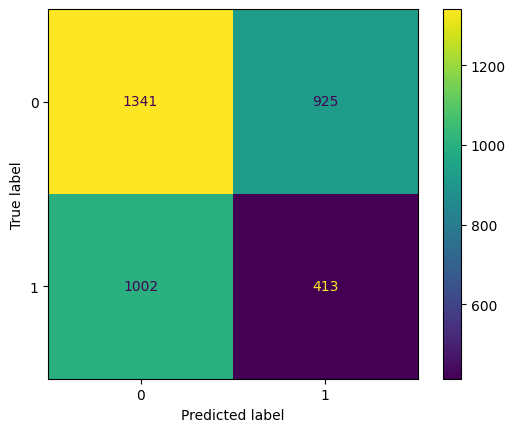

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.561824253555756
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2266
           1       0.34      0.33      0.34      1415

    accuracy                           0.50      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.50      0.50      3681



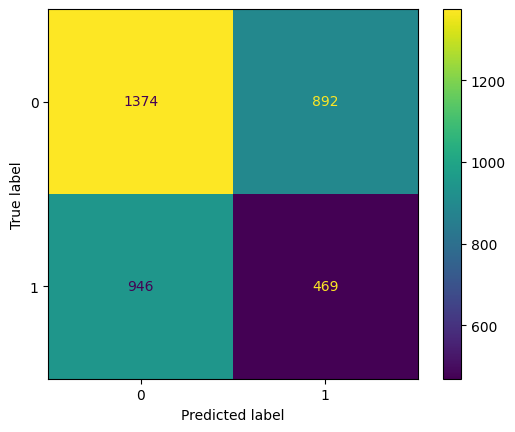

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.5850156593898624
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2266
           1       0.61      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.64      0.66      0.62      3681



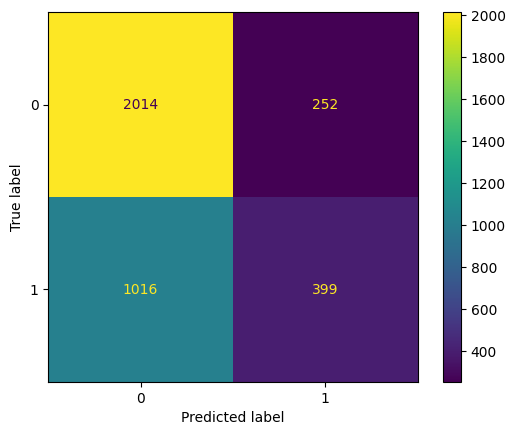

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5680195155162826
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      2266
           1       0.58      0.32      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.63      0.59      0.58      3681
weighted avg       0.64      0.65      0.62      3681



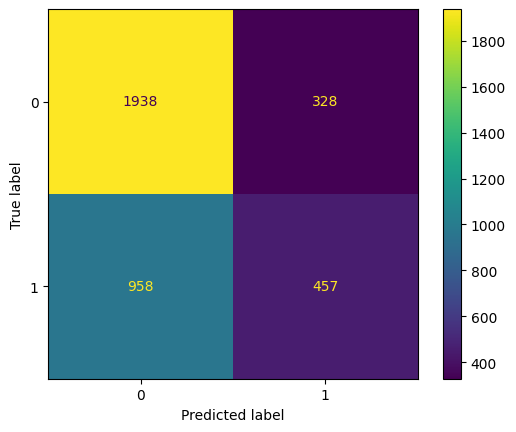

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5730399200287358
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      2266
           1       0.51      0.27      0.35      1415

    accuracy                           0.62      3681
   macro avg       0.58      0.55      0.54      3681
weighted avg       0.59      0.62      0.59      3681



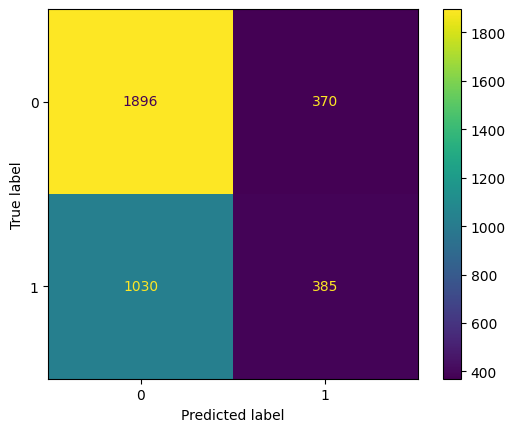

NUMBER OF FEATURES SELECTED:  30
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.5541213000500653
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      2266
           1       0.47      0.50      0.48      1415

    accuracy                           0.59      3681
   macro avg       0.57      0.57      0.57      3681
weighted avg       0.59      0.59      0.59      3681



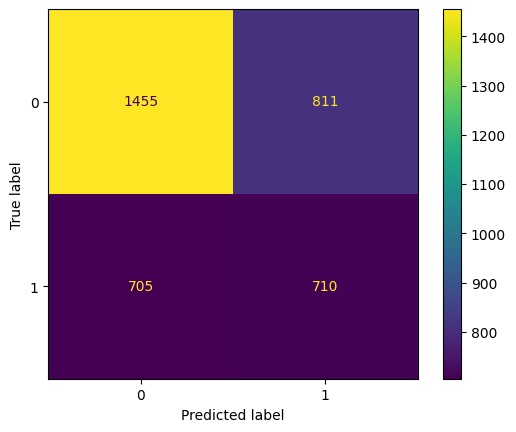

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5011813248478318
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      2266
           1       0.43      0.31      0.36      1415

    accuracy                           0.58      3681
   macro avg       0.53      0.53      0.52      3681
weighted avg       0.56      0.58      0.56      3681



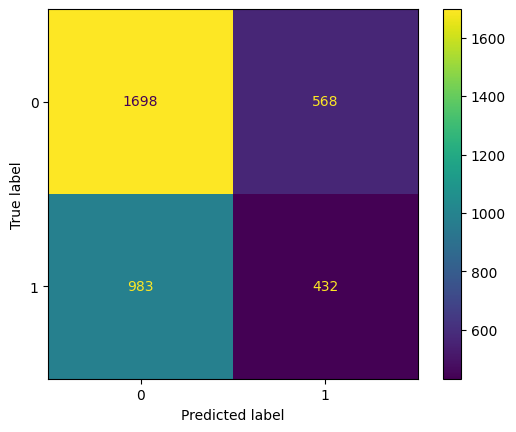

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.49851259374882184
              precision    recall  f1-score   support

           0       0.67      0.77      0.71      2266
           1       0.51      0.38      0.44      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.58      0.58      3681
weighted avg       0.61      0.62      0.61      3681



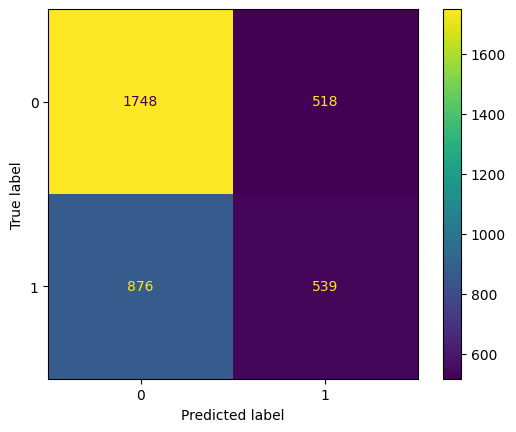

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5217594359891209
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      2266
           1       0.29      0.28      0.29      1415

    accuracy                           0.47      3681
   macro avg       0.43      0.43      0.43      3681
weighted avg       0.46      0.47      0.46      3681



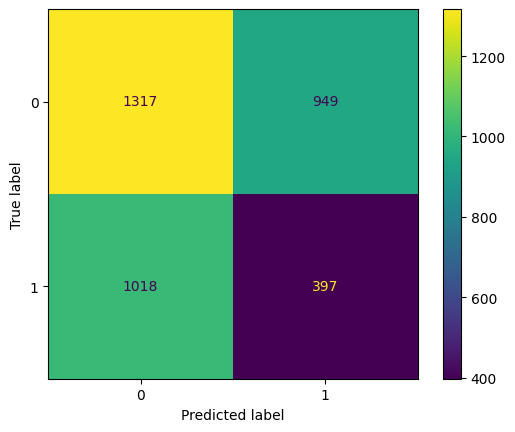

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5718522719094024
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      2266
           1       0.33      0.30      0.32      1415

    accuracy                           0.50      3681
   macro avg       0.46      0.46      0.46      3681
weighted avg       0.49      0.50      0.49      3681



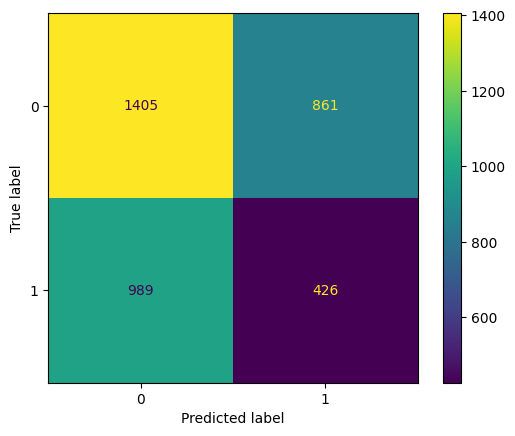

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6003093788787791
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      2266
           1       0.62      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



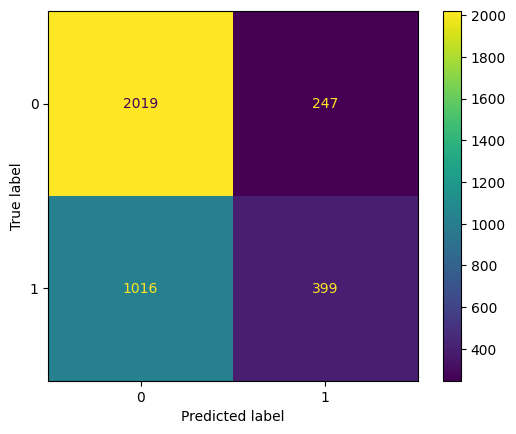

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.576946200814423
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2266
           1       0.57      0.32      0.41      1415

    accuracy                           0.65      3681
   macro avg       0.62      0.58      0.58      3681
weighted avg       0.63      0.65      0.62      3681



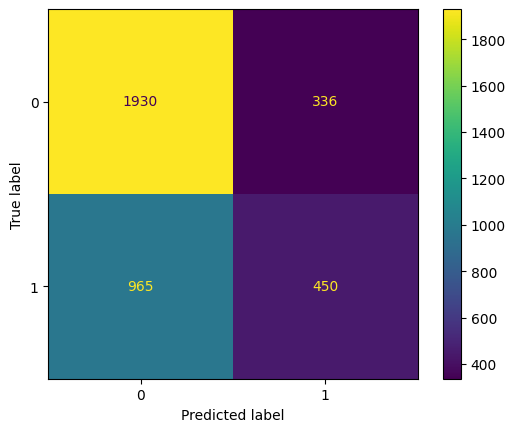

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5807991412747264
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2266
           1       0.53      0.25      0.34      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.56      0.54      3681
weighted avg       0.60      0.63      0.59      3681



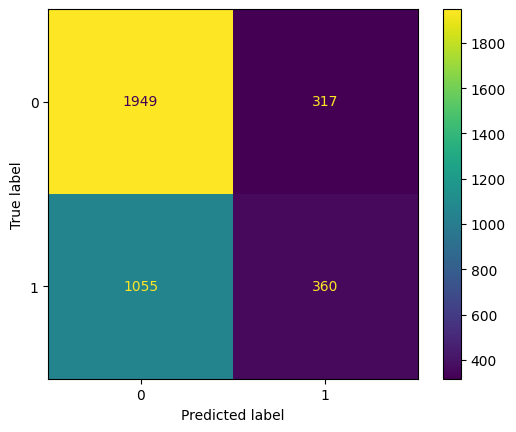

NUMBER OF FEATURES SELECTED:  40
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.5541646136540646
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      2266
           1       0.46      0.53      0.49      1415

    accuracy                           0.58      3681
   macro avg       0.56      0.57      0.56      3681
weighted avg       0.59      0.58      0.58      3681



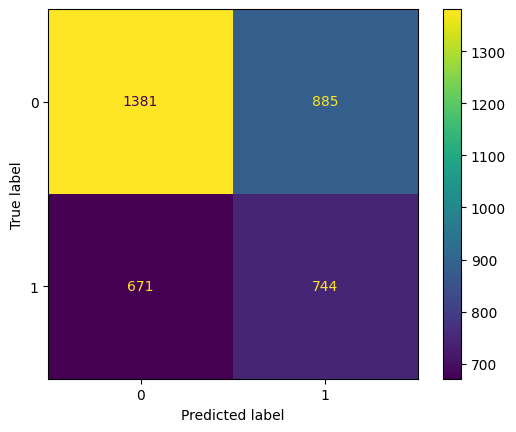

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.4445563944664871
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      2266
           1       0.42      0.29      0.34      1415

    accuracy                           0.57      3681
   macro avg       0.52      0.52      0.51      3681
weighted avg       0.55      0.57      0.55      3681



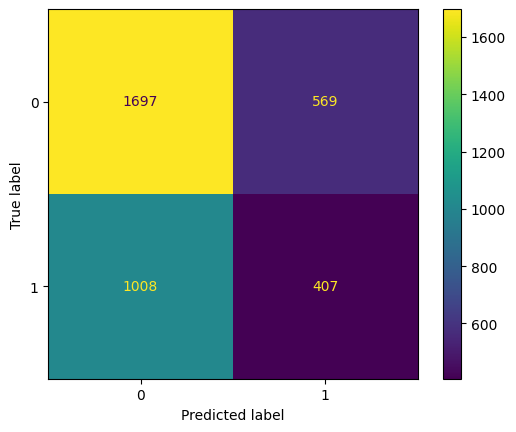

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.4996529955097556
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      2266
           1       0.51      0.38      0.43      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.60      0.62      0.61      3681



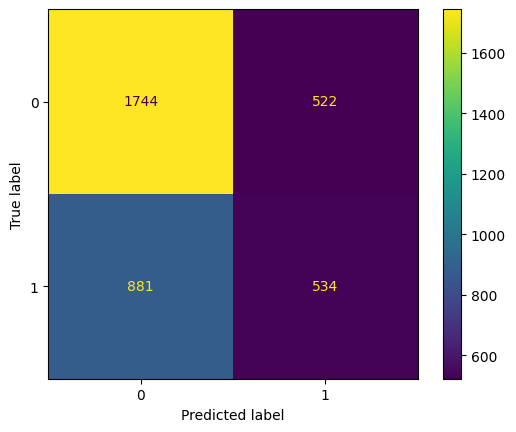

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5242126934022162
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      2266
           1       0.30      0.28      0.29      1415

    accuracy                           0.47      3681
   macro avg       0.43      0.43      0.43      3681
weighted avg       0.46      0.47      0.47      3681



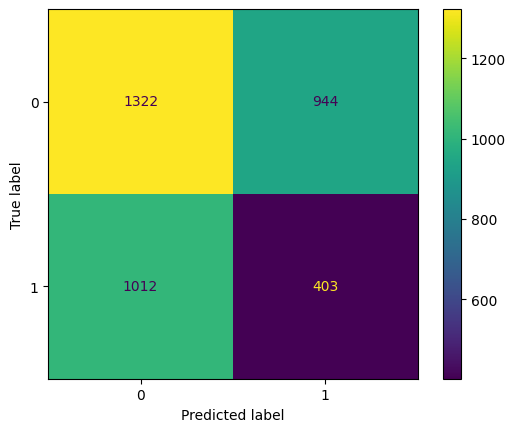

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5742231458385981
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      2266
           1       0.34      0.30      0.32      1415

    accuracy                           0.51      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.51      0.50      3681



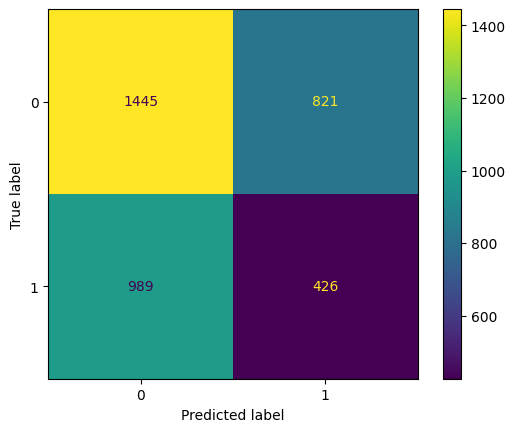

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6024055816874947
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      2266
           1       0.62      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



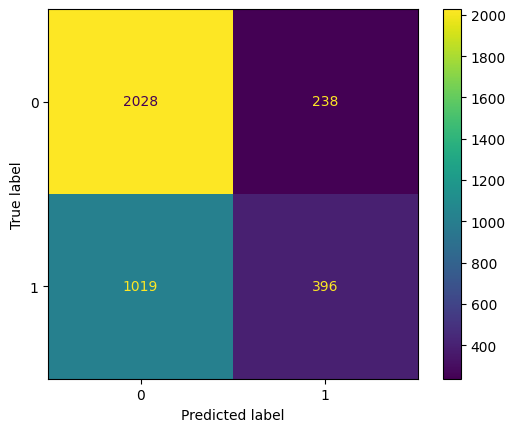

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.577048731979588
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2266
           1       0.58      0.32      0.41      1415

    accuracy                           0.65      3681
   macro avg       0.62      0.59      0.58      3681
weighted avg       0.63      0.65      0.62      3681



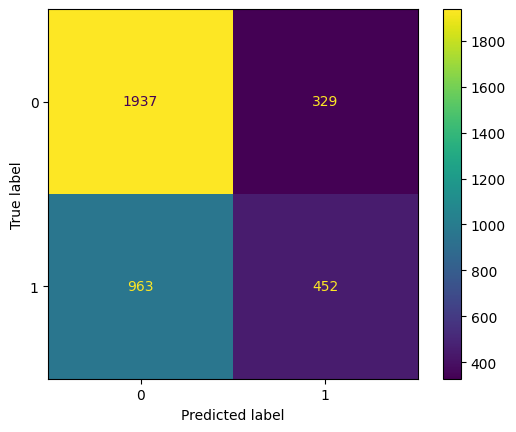

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5814480848415541
              precision    recall  f1-score   support

           0       0.65      0.87      0.75      2266
           1       0.56      0.26      0.35      1415

    accuracy                           0.64      3681
   macro avg       0.60      0.56      0.55      3681
weighted avg       0.62      0.64      0.59      3681



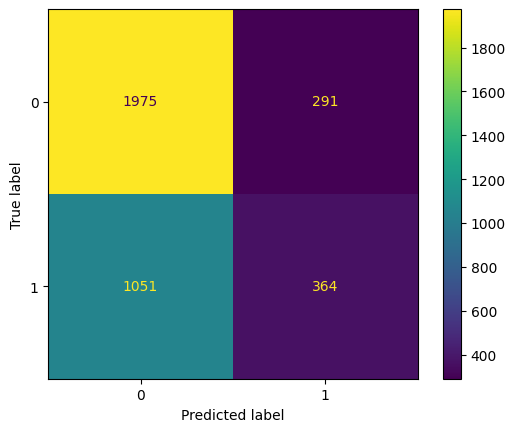

NUMBER OF FEATURES SELECTED:  50
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.5099449047926672
              precision    recall  f1-score   support

           0       0.67      0.56      0.61      2266
           1       0.44      0.56      0.49      1415

    accuracy                           0.56      3681
   macro avg       0.56      0.56      0.55      3681
weighted avg       0.58      0.56      0.56      3681



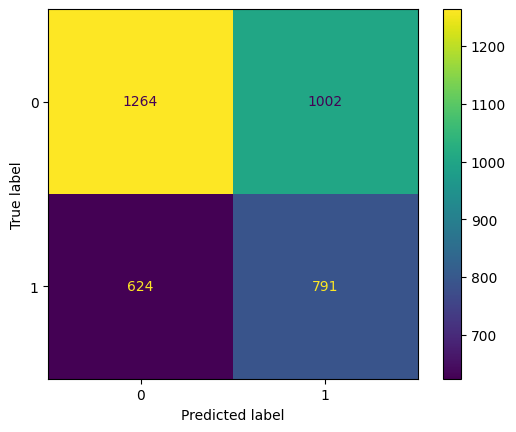

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5497124869610529
              precision    recall  f1-score   support

           0       0.65      0.36      0.46      2266
           1       0.40      0.69      0.51      1415

    accuracy                           0.48      3681
   macro avg       0.52      0.52      0.48      3681
weighted avg       0.55      0.48      0.48      3681



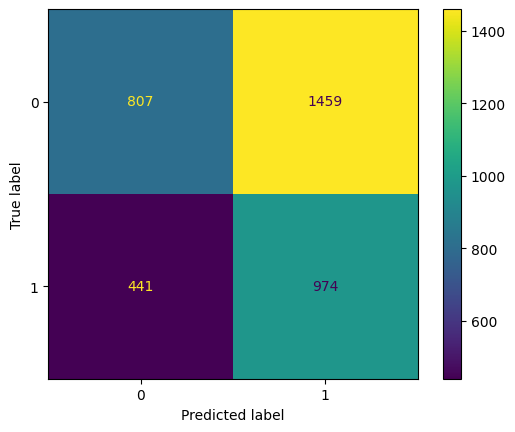

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.5025405925836586
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      2266
           1       0.51      0.38      0.44      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.58      0.58      3681
weighted avg       0.61      0.62      0.61      3681



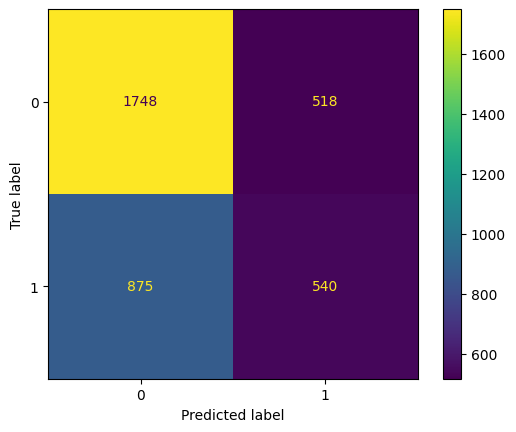

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5250965380513414
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      2266
           1       0.30      0.28      0.29      1415

    accuracy                           0.47      3681
   macro avg       0.43      0.43      0.43      3681
weighted avg       0.46      0.47      0.46      3681



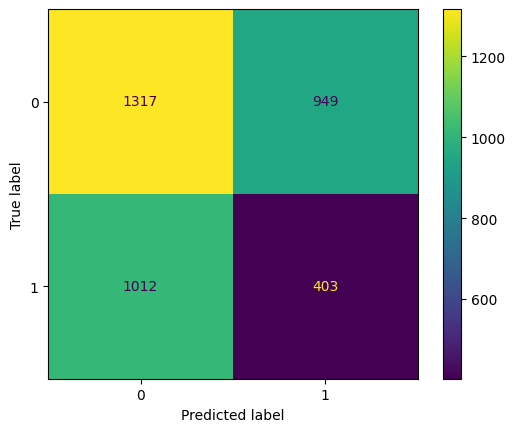

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5786469434094963
              precision    recall  f1-score   support

           0       0.60      0.65      0.62      2266
           1       0.35      0.29      0.32      1415

    accuracy                           0.51      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.51      0.51      3681



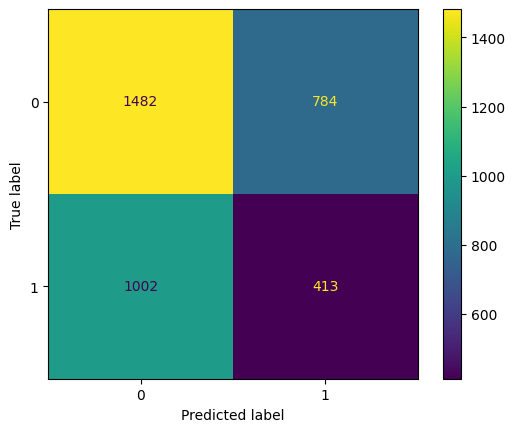

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6049459040140928
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      2266
           1       0.62      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



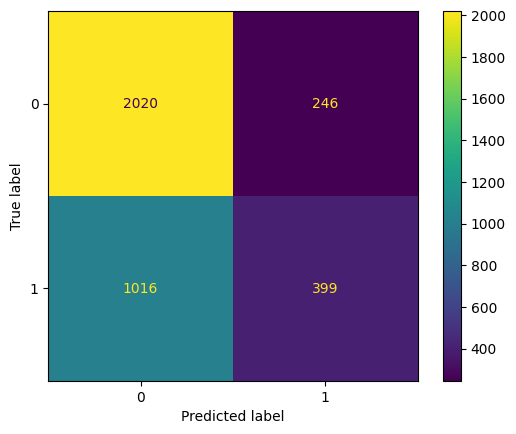

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5768644556730749
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      2266
           1       0.58      0.32      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.63      0.59      0.58      3681
weighted avg       0.64      0.65      0.62      3681



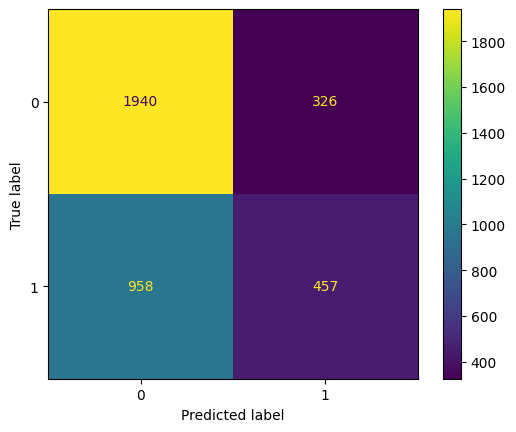

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5847782809721167
              precision    recall  f1-score   support

           0       0.65      0.87      0.74      2266
           1       0.54      0.25      0.34      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.56      0.54      3681
weighted avg       0.61      0.63      0.59      3681



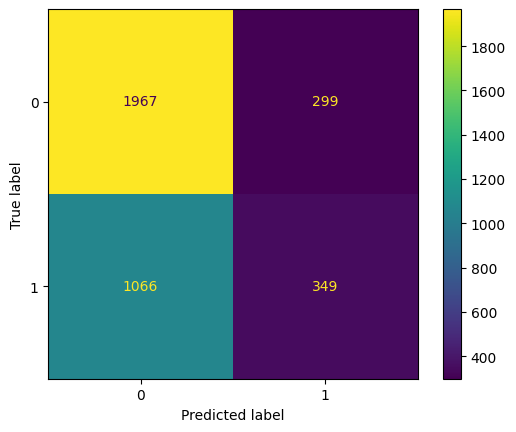

NUMBER OF FEATURES SELECTED:  60
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.4999725858810914
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      2266
           1       0.44      0.59      0.50      1415

    accuracy                           0.55      3681
   macro avg       0.56      0.56      0.55      3681
weighted avg       0.58      0.55      0.56      3681



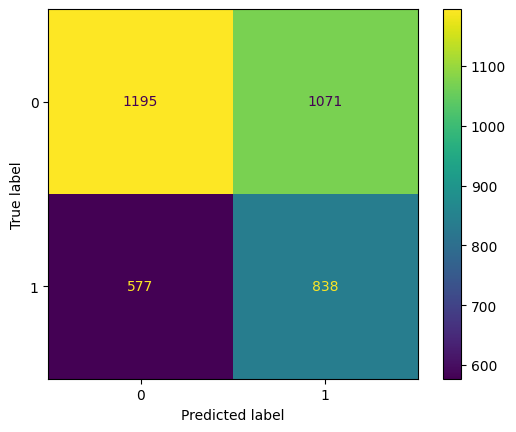

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5481500034968502
              precision    recall  f1-score   support

           0       0.64      0.40      0.49      2266
           1       0.40      0.63      0.49      1415

    accuracy                           0.49      3681
   macro avg       0.52      0.52      0.49      3681
weighted avg       0.55      0.49      0.49      3681



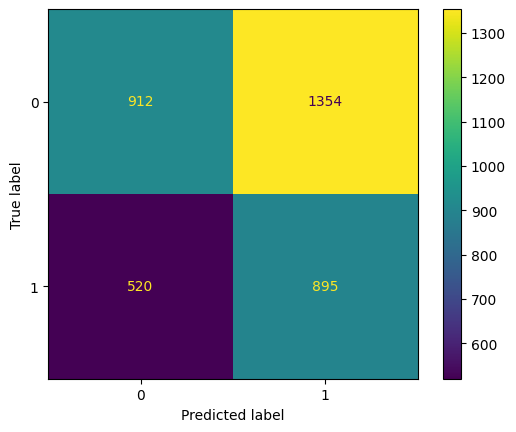

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.5004457193721479
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      2266
           1       0.50      0.39      0.44      1415

    accuracy                           0.62      3681
   macro avg       0.59      0.57      0.57      3681
weighted avg       0.60      0.62      0.61      3681



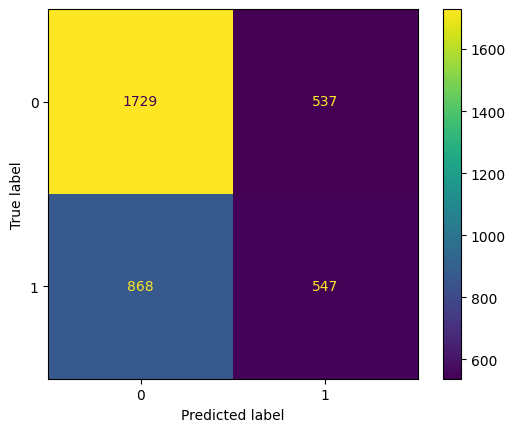

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5249113764973867
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2266
           1       0.31      0.30      0.30      1415

    accuracy                           0.47      3681
   macro avg       0.44      0.44      0.44      3681
weighted avg       0.47      0.47      0.47      3681



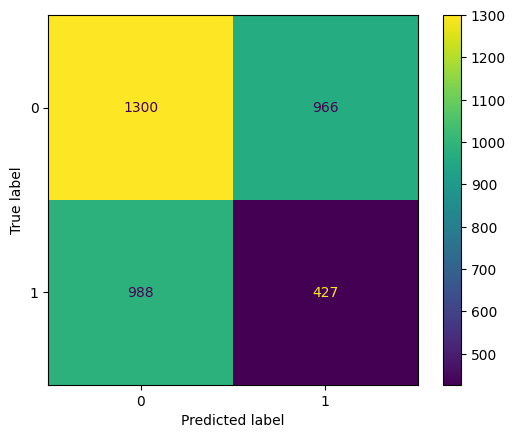

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5838967758868584
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      2266
           1       0.35      0.29      0.32      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.48      0.47      3681
weighted avg       0.50      0.52      0.51      3681



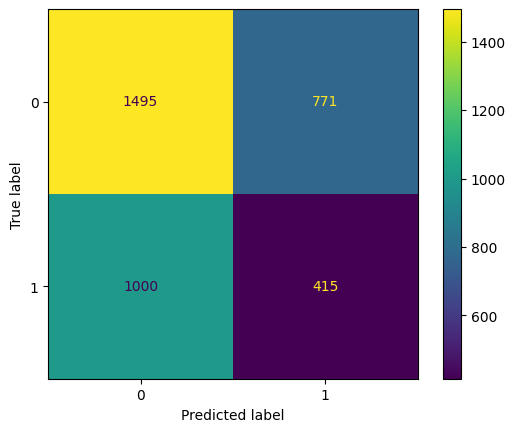

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6076308145360431
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2266
           1       0.62      0.28      0.38      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



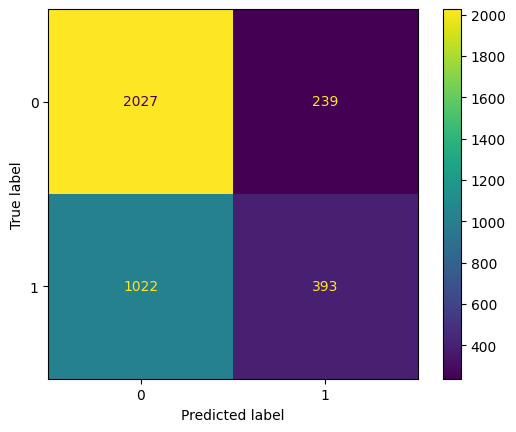

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5768644556730749
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      2266
           1       0.58      0.32      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.63      0.59      0.58      3681
weighted avg       0.64      0.65      0.62      3681



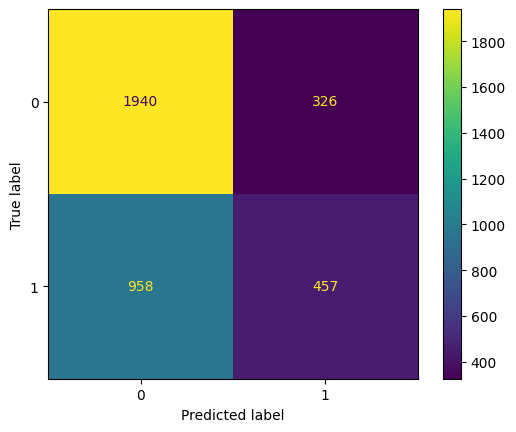

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5847691769540779
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2266
           1       0.54      0.25      0.34      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.56      0.54      3681
weighted avg       0.61      0.63      0.59      3681



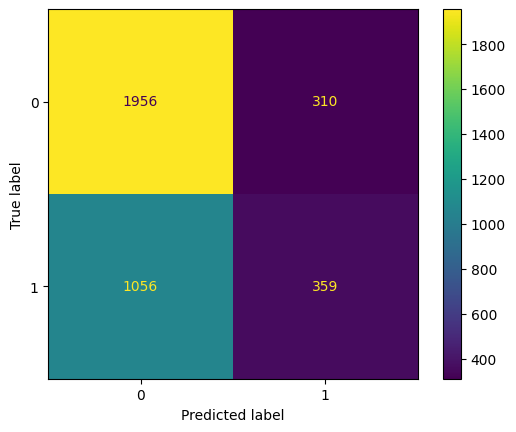

NUMBER OF FEATURES SELECTED:  70
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.5225585329672077
              precision    recall  f1-score   support

           0       0.67      0.45      0.54      2266
           1       0.42      0.65      0.51      1415

    accuracy                           0.53      3681
   macro avg       0.55      0.55      0.53      3681
weighted avg       0.58      0.53      0.53      3681



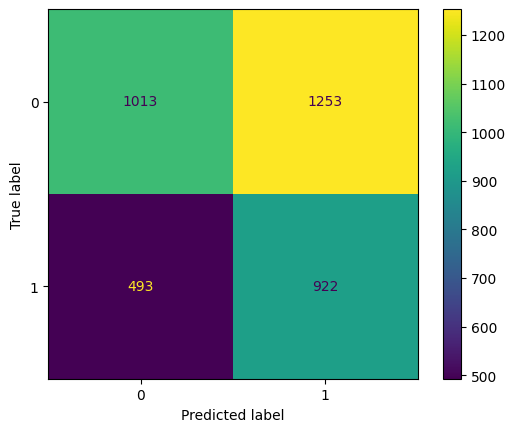

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.527819915164806
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      2266
           1       0.43      0.31      0.36      1415

    accuracy                           0.58      3681
   macro avg       0.53      0.53      0.52      3681
weighted avg       0.56      0.58      0.56      3681



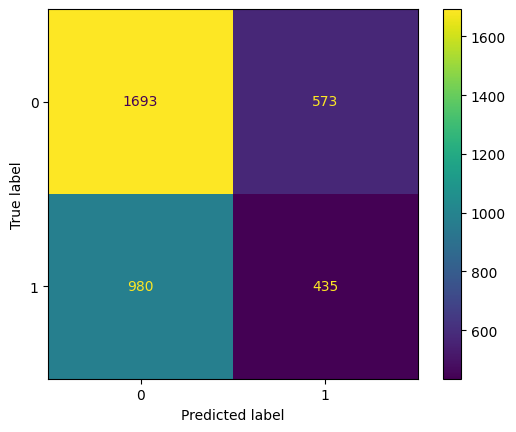

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.5030673401835468
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      2266
           1       0.50      0.38      0.43      1415

    accuracy                           0.62      3681
   macro avg       0.58      0.57      0.57      3681
weighted avg       0.60      0.62      0.60      3681



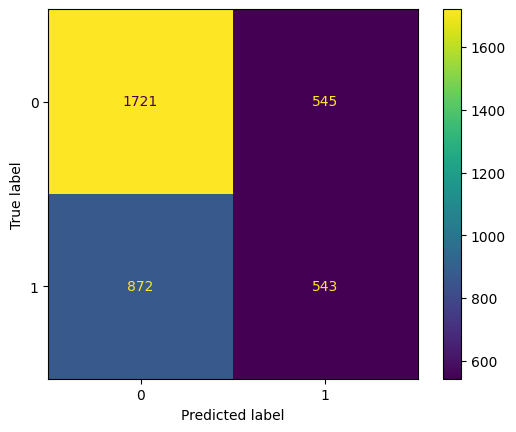

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.524866630520752
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      2266
           1       0.31      0.30      0.30      1415

    accuracy                           0.48      3681
   macro avg       0.44      0.44      0.44      3681
weighted avg       0.47      0.48      0.48      3681



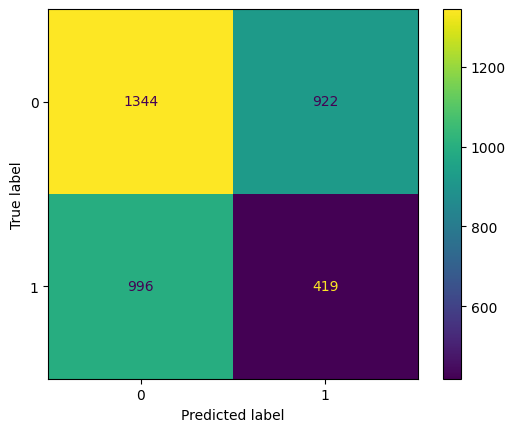

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5813893179806853
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      2266
           1       0.35      0.28      0.31      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.52      0.51      3681



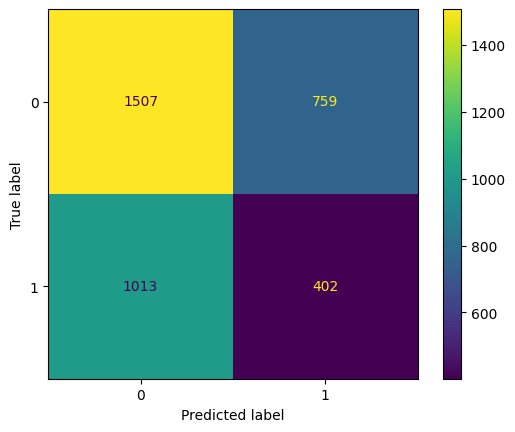

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6100589190987814
              precision    recall  f1-score   support

           0       0.67      0.90      0.76      2266
           1       0.62      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.65      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



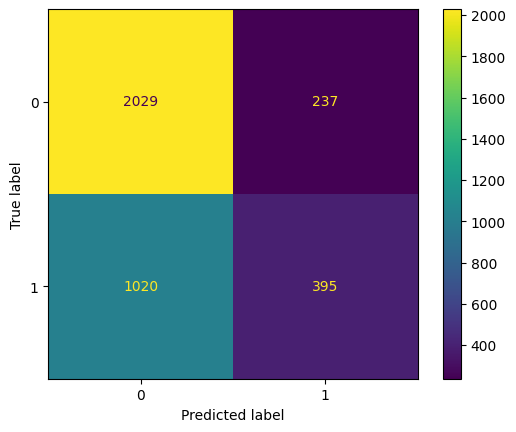

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5787516688986025
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2266
           1       0.57      0.33      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.62      0.59      0.58      3681
weighted avg       0.63      0.65      0.62      3681



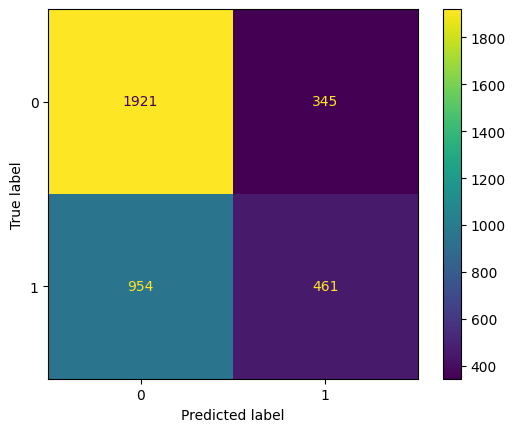

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5807974217909075
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2266
           1       0.56      0.25      0.34      1415

    accuracy                           0.63      3681
   macro avg       0.60      0.56      0.55      3681
weighted avg       0.61      0.63      0.59      3681



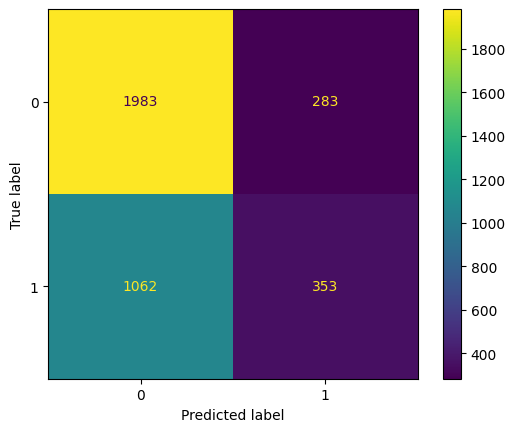

NUMBER OF FEATURES SELECTED:  80
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.5087698529161107
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      2266
           1       0.51      0.35      0.41      1415

    accuracy                           0.62      3681
   macro avg       0.58      0.57      0.57      3681
weighted avg       0.60      0.62      0.60      3681



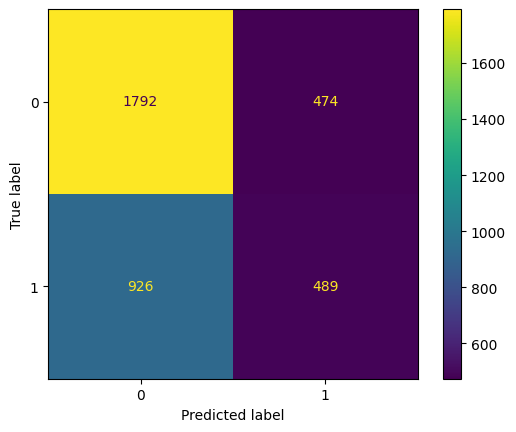

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.39796402279887094
              precision    recall  f1-score   support

           0       0.61      0.80      0.69      2266
           1       0.34      0.16      0.22      1415

    accuracy                           0.56      3681
   macro avg       0.47      0.48      0.46      3681
weighted avg       0.50      0.56      0.51      3681



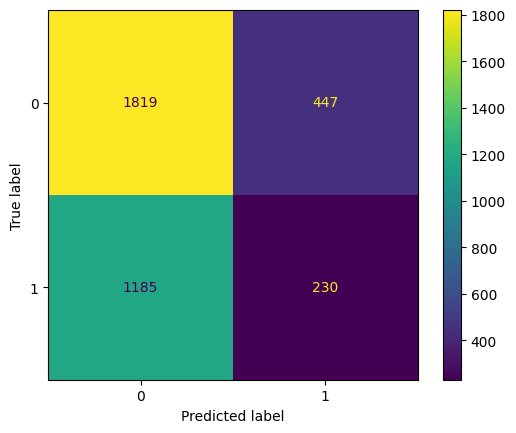

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.5029895709411838
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      2266
           1       0.50      0.38      0.43      1415

    accuracy                           0.61      3681
   macro avg       0.58      0.57      0.57      3681
weighted avg       0.60      0.61      0.60      3681



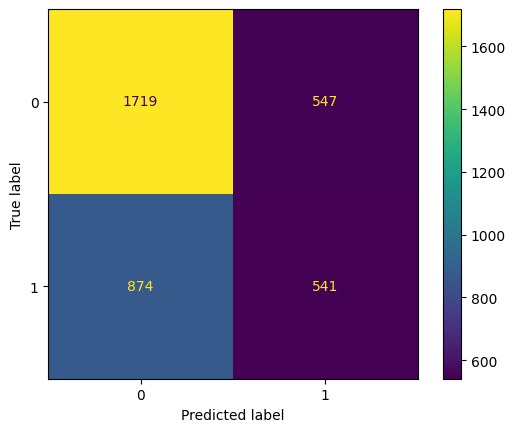

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5252608174305161
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      2266
           1       0.30      0.30      0.30      1415

    accuracy                           0.47      3681
   macro avg       0.44      0.44      0.44      3681
weighted avg       0.47      0.47      0.47      3681



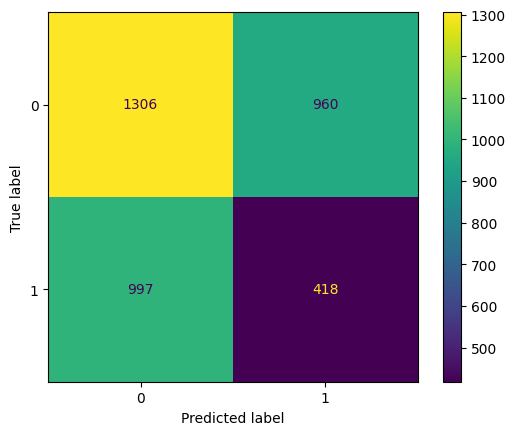

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5832323070336238
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      2266
           1       0.35      0.28      0.31      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.47      0.47      3681
weighted avg       0.50      0.52      0.51      3681



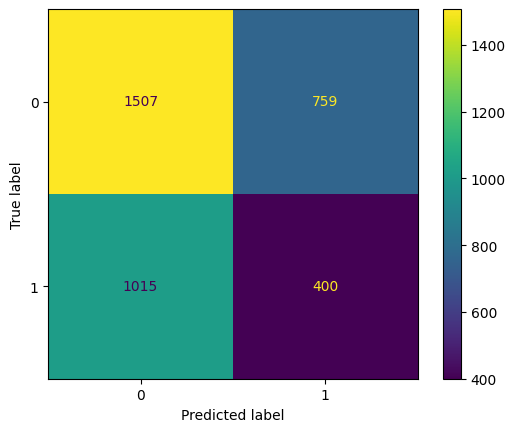

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6115002996981053
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      2266
           1       0.62      0.28      0.39      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



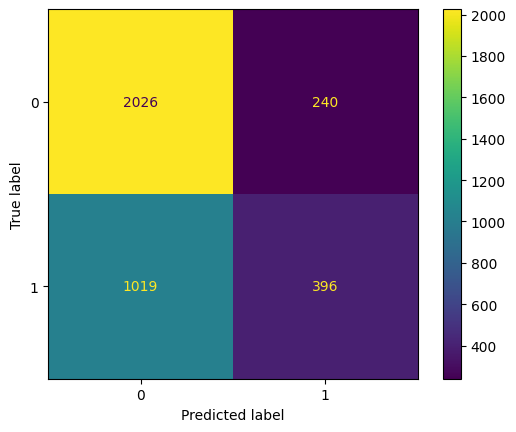

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5787516688986025
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2266
           1       0.57      0.33      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.62      0.59      0.58      3681
weighted avg       0.63      0.65      0.62      3681



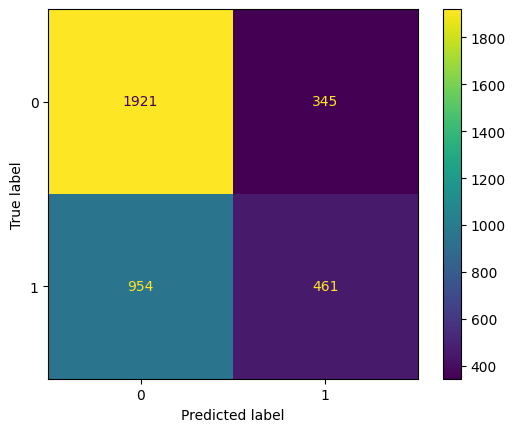

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5782853430313388
              precision    recall  f1-score   support

           0       0.65      0.87      0.74      2266
           1       0.54      0.25      0.34      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.56      0.54      3681
weighted avg       0.61      0.63      0.59      3681



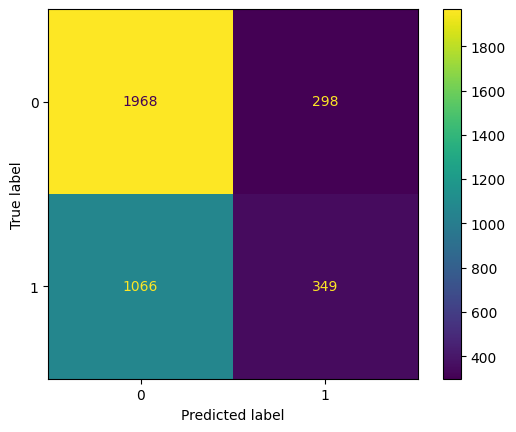

NUMBER OF FEATURES SELECTED:  84
MODEL:  SGD_SVM
Training score without hyperparameter tuning based on f1 score is 0.48120532854061865
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      2266
           1       0.53      0.30      0.38      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.57      0.56      3681
weighted avg       0.61      0.63      0.60      3681



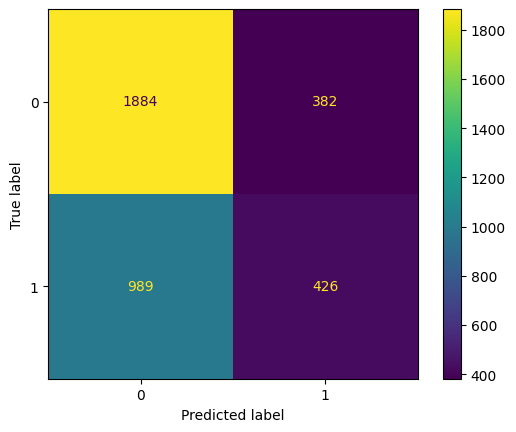

MODEL:  SGD_perceptron
Training score without hyperparameter tuning based on f1 score is 0.5545237218479633
              precision    recall  f1-score   support

           0       0.64      0.38      0.48      2266
           1       0.40      0.66      0.50      1415

    accuracy                           0.49      3681
   macro avg       0.52      0.52      0.49      3681
weighted avg       0.55      0.49      0.49      3681



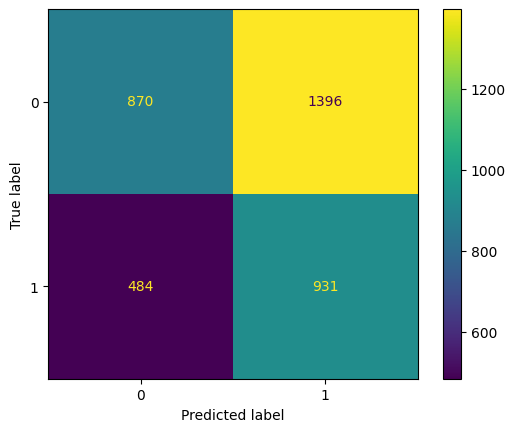

MODEL:  Logistic
Training score without hyperparameter tuning based on f1 score is 0.5027204549139943
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      2266
           1       0.50      0.38      0.43      1415

    accuracy                           0.62      3681
   macro avg       0.58      0.57      0.57      3681
weighted avg       0.60      0.62      0.60      3681



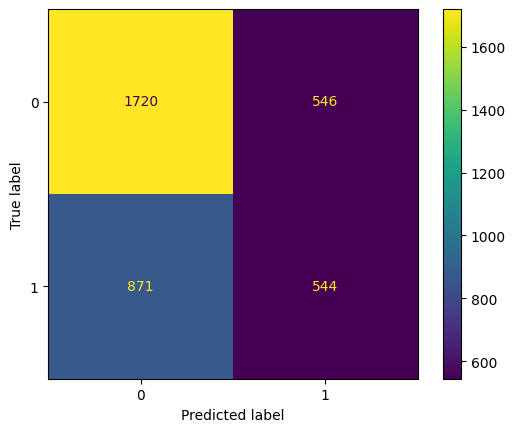

MODEL:  dt
Training score without hyperparameter tuning based on f1 score is 0.5248534841309942
              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2266
           1       0.30      0.29      0.29      1415

    accuracy                           0.46      3681
   macro avg       0.43      0.43      0.43      3681
weighted avg       0.46      0.46      0.46      3681



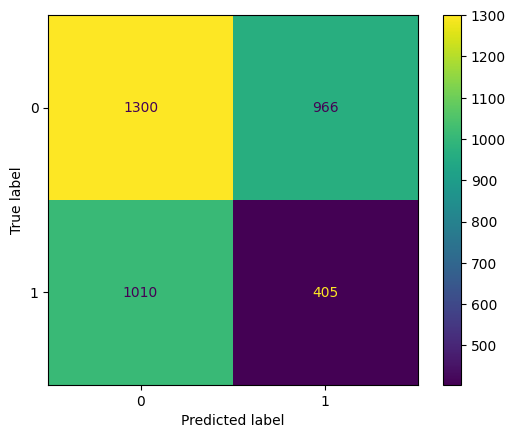

MODEL:  rfc
Training score without hyperparameter tuning based on f1 score is 0.5829157850838608
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      2266
           1       0.35      0.29      0.31      1415

    accuracy                           0.52      3681
   macro avg       0.47      0.48      0.47      3681
weighted avg       0.50      0.52      0.51      3681



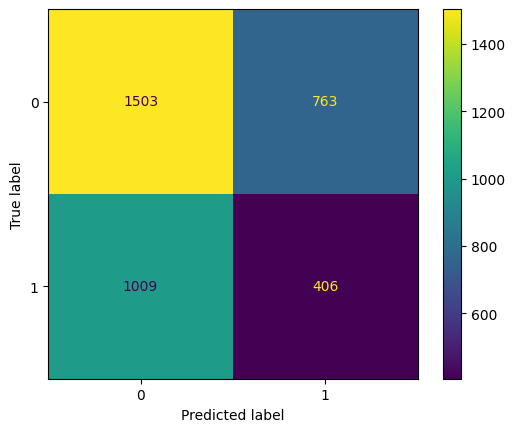

MODEL:  gb
Training score without hyperparameter tuning based on f1 score is 0.6102496920809491
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2266
           1       0.62      0.28      0.38      1415

    accuracy                           0.66      3681
   macro avg       0.64      0.59      0.57      3681
weighted avg       0.65      0.66      0.62      3681



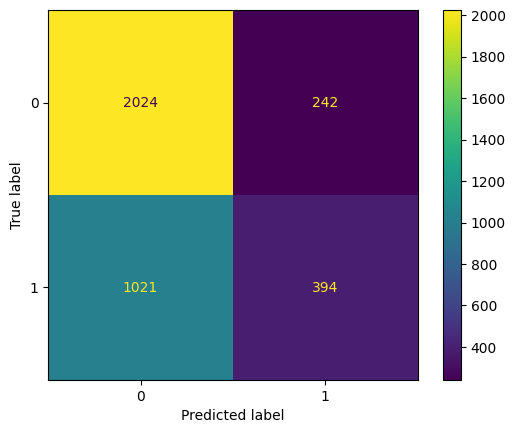

MODEL:  adb
Training score without hyperparameter tuning based on f1 score is 0.5787516688986025
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2266
           1       0.57      0.33      0.42      1415

    accuracy                           0.65      3681
   macro avg       0.62      0.59      0.58      3681
weighted avg       0.63      0.65      0.62      3681



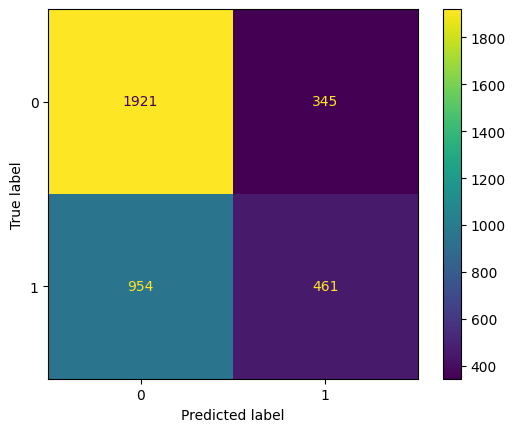

MODEL:  xgb
Training score without hyperparameter tuning based on f1 score is 0.5793069190152905
              precision    recall  f1-score   support

           0       0.65      0.87      0.74      2266
           1       0.53      0.24      0.33      1415

    accuracy                           0.63      3681
   macro avg       0.59      0.55      0.54      3681
weighted avg       0.60      0.63      0.58      3681



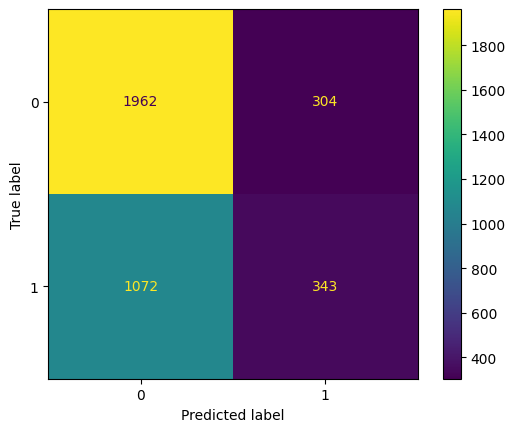

In [254]:
for k in k_s:
  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_res, y_res)
  X_test_selected = selector.transform(X_test)
  print("NUMBER OF FEATURES SELECTED: ", k)
  for name, model in models:
    print("MODEL: ", name)
    train_classifier(X_train_selected, y_res, model)
    evaluation(model, X_train_selected, y_res, X_test_selected, y_test)

#### These models are not able to identify 1s correctly. Lets try hyperparameter tuning.

In [ ]:
# est = LogisticRegression(class_weight='balanced', random_state=42)
# train_classifier(X_train, y_train, est)

# param_grid = {
#     'C' : [0.3, 0.5, 1, 8, 15, 25],
#     'max_iter': [100, 200, 300]
# }

# #RandomizedSearch(X_train, y_train, param_grid, est)


# # Training score without hyperparameter tuning based on f1 score is 0.4754765356414026
# # Best params are {'max_iter': 300, 'C': 1}. Best score is 0.4754765356414026


# evaluation(LogisticRegression(class_weight='balanced', random_state=42, max_iter=300, C=1), X_train, y_train, X_test, y_test)

In [ ]:
# dt = DecisionTreeClassifier(random_state=24, class_weight='balanced')
# train_classifier(X_train, y_train, dt)

# param_grid = {
#     'max_depth' : [2, 4, 8, 14, 20],
#     'min_samples_split': [0.5, 0.7, 0.9],
#     'min_samples_leaf': [0.007, 0.01, 0.05, 0.1],
#     'max_features': [0.5, 0.7, 0.8, 1],
# }

# #RandomizedSearch(X_train, y_train, param_grid, dt)
# #Training score without hyperparameter tuning based on f1 score is 0.5401003675953224
# #Best params are {'min_samples_split': 0.5, 'min_samples_leaf': 0.05, 'max_features': 0.5, 'max_depth': 2}. Best score is 0.5992884972188838

# evaluation(DecisionTreeClassifier(random_state=24, class_weight='balanced',  min_samples_split=0.5, min_samples_leaf=0.05, max_features=0.5, max_depth=2), X_train, y_train, X_test, y_test)

In [ ]:
# rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# train_classifier(X_train, y_train, rfc)

# param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [2, 4, 6, 8],
#     'min_samples_split': [0.5, 0.7, 0.9],
#     'min_samples_leaf': [0.007, 0.01, 0.05, 0.1],
#     'max_features': [0.5, 0.7, 0.8, 1],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# RandomizedSearch(X_train, y_train, param_grid, rfc)

# # Training score without hyperparameter tuning based on f1 score is 0.6016681031682852
# # Best params are {'n_estimators': 200, 'min_samples_split': 0.5, 'min_samples_leaf': 0.05, 'max_features': 1, 'max_depth': 4, 'class_weight': 'balanced_subsample'}. Best score is 0.5935


# evaluation(RandomForestClassifier(random_state=42, n_estimators= 200, min_samples_split= 0.5, min_samples_leaf= 0.05, max_features=1, max_depth= 4, class_weight= 'balanced_subsample'), X_train, y_train, X_test, y_test)

In [ ]:
# base_est = DecisionTreeClassifier(random_state=24, class_weight='balanced',  min_samples_split=0.9, min_samples_leaf=0.05, max_features=0.5, max_depth=8)
# adb = AdaBoostClassifier(estimator = base_est, random_state=42)

# train_classifier(X_train, y_train, adb)

# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'learning_rate': [0.1, 0.5, 1, 2, 4, 6],
# }

# #RandomizedSearch(X_train, y_train, param_grid, adb)

# # Training score without hyperparameter tuning based on f1 score is 0.6237005718289441
# # Best params are {'n_estimators': 200, 'learning_rate': 1}. Best score is 0.6581809515912066

# evaluation(AdaBoostClassifier(estimator = base_est, random_state=42, n_estimators = 200, learning_rate=1), X_train, y_train, X_test, y_test)

In [ ]:
# xgb = XGBClassifier(objective='binary:logistic')
# train_classifier(X_train , y_train, xgb)

# param_grid = {
#     'eta': [0.1, 0.3, 0.6],
#     'gamma': [0, 2, 3, 4],
#     'max_depth': [2, 4, 6, 10],
#     'subsample': [0.5, 0.7, 0.9],
#     'colsample_bytree': [0.5, 0.7, 0.9],
#     'reg_lambda': [1, 3, 5],
#     'alpha': [0, 1, 3],
#     'scale_pos_weight': [1, 1.2, 1.5]
# }

# # RandomizedSearch(X_train, y_train, param_grid, xgb)

# # Training score without hyperparameter tuning based on f1 score is 0.6275207300739587
# # Best params are {'subsample': 0.7, 'scale_pos_weight': 1, 'max_depth': 2, 'lambda': 31, 'gamma': 20, 'eta': 0.1, 'colsample_bytree': 0.7, 'alpha': 1}. Best score is 0.43509

# evaluation(XGBClassifier(objective='binary:logistic', seed=42, eta=0.1, max_depth=2, gamma=20, reg_lambda=31, scale_pos_weight=1, subsample=0.7, colsample_bytree=0.7), X_train, y_train, X_test, y_test)

In [ ]:
# base_est = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# bgc = BaggingClassifier(estimator = base_est, random_state=42)

# train_classifier(X_train, y_train, bgc)

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_samples': [0.5, 0.7, 0.9],
#     'max_features': [0.5, 0.7, 0.9],
# }

# #RandomizedSearch(X_train, y_train, param_grid, bgc)
# # Training score without hyperparameter tuning based on f1 score is 0.5816556209450856
# # Best params are {'n_estimators': 100, 'max_samples': 0.9, 'max_features': 0.7}. Best score is 0.6117666812866308
# evaluation(BaggingClassifier(estimator = base_est, random_state=42, n_estimators=100, max_samples=0.9, max_features=0.7), X_train, y_train, X_test, y_test)

### Try stacking classifier

In [267]:
stacking_classifier = StackingClassifier(estimators=models)

stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)


Test Accuracy: 0.7296930182015756
F1 score: <function f1_score at 0x7fd63aeb0820>


In [268]:
print("Test Accuracy:", accuracy)
print("F1 score:", f1score)

Test Accuracy: 0.7296930182015756
F1 score: 0.5810526315789474


              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2266
           1       0.72      0.49      0.58      1415

    accuracy                           0.73      3681
   macro avg       0.73      0.68      0.69      3681
weighted avg       0.73      0.73      0.72      3681



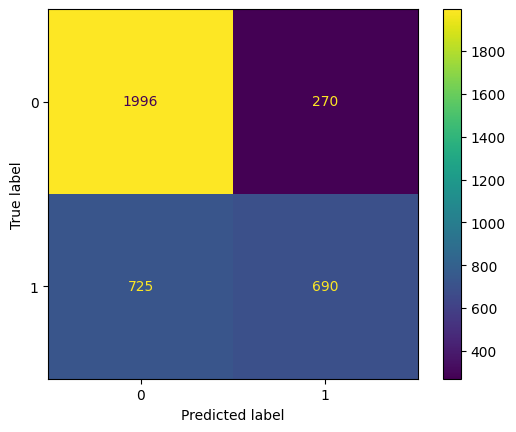

In [269]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Oversampled data: Stacking Classifier

In [272]:
stacking_classifier_res = StackingClassifier(estimators=models)

stacking_classifier_res.fit(X_res, y_res)

y_pred_res = stacking_classifier_res.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_res)
f1score = f1_score(y_test, y_pred_res)
print("Test Accuracy:", accuracy)
print("F1 score:", f1score)

Test Accuracy: 0.7011681608258625
F1 score: 0.5624502784407319


              precision    recall  f1-score   support

           0       0.73      0.83      0.77      2266
           1       0.64      0.50      0.56      1415

    accuracy                           0.70      3681
   macro avg       0.68      0.66      0.67      3681
weighted avg       0.69      0.70      0.69      3681



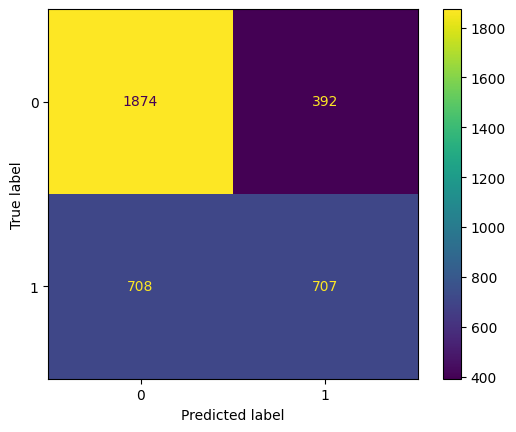

In [273]:
print(classification_report(y_test, y_pred_res))
cm = confusion_matrix(y_test, y_pred_res)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Final Model

In [280]:
y_pred = stacking_classifier_res.predict(df_test_p)
y_pred = np.array(y_pred, dtype=bool)
row_id = np.arange(6599)
data = {'id':row_id, 'Made_Purchase':y_pred}
submission = pd.DataFrame(data=data)
submission.to_csv('submission.csv', index=False)